REMARK: Difference of notations between this notebook and the article:

* Mixed layer depth is < 0 in the code (vs > 0 in the article)
* N2eq in the code is the N2h of the article
* LIONb is the "Western Mediterranean" region, LABs is the "Labrador" region

All the analyses are presented here. For simplicity, these calculations have been already done and the results are provided in the npz archives available at https://doi.org/10.5281/zenodo.7944781. Thus, you have just to execute the "Imports" and "Functions" sections and then directly go to the header "Figures of the article" to realize all the figures presented in the article. For that, you have just to set-up the variable "path_to_npz_archives" just below with the path of the folder where you stored these archives.

PS: For a better readability of the Notebook, please install the "jupyter_contrib_nbextensions" and activate the "Collapsible Headings" + "Codefolding" extensions.

In [1]:
path_to_npz_archives = '/toto/'

# Imports

In [2]:
### NOT mandatory
### Opening a dask cluster for accelerating the calculations and for reducing memory leaks that 
### sometimes appear in Jupyter Notebook
### The dashboard for following the dask cluster is accessible at http://localhost:8777/status
#
#import dask
#import dask.threaded
#import dask.multiprocessing
#from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster(n_workers = 4, processes = True, dashboard_address=':8777')
#client = Client(cluster)
#client  # for showing the characteristic of the cluster

In [3]:
#!/usr/bin/env python
# coding: utf-8

# ===================
#      Imports
# ===================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import gsw
import warnings
from scipy import interpolate
#sys.path.append(r'/scm_oce/')     ### Fortran module for the 1D simulations
#from scm_oce import scm_oce       ### Fortran module for the 1D simulations
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy
from os.path import exists
from matplotlib.ticker import FormatStrFormatter, LogLocator

plt.rcParams['figure.figsize'] = (15,8)  #(6.8,4.5)
plt.rcParams.update({'font.size': 15})

# Functions

In [4]:
### Functions for realizing the hexbin plots

def SymLogTicks(vmin, vmax, linthresh):  
    """Function for adding ticks when using a symlog colorbar scale."""
    log_max = int(np.ceil(np.log10(vmax)))
    log_min = int(np.ceil(np.log10(-vmin)))
    log_linthresh = int(np.floor(np.log10(linthresh)))
    tick_locations = np.array( [vmin]
                       + [-a*(10.0**x) for x in range(log_min-1,log_linthresh-1,-1) for a in range(9,0,-1)]
                       + [0.0]
                       + [a*(10.0**x) for x in range(log_linthresh,log_max) for a in range(1,10)]
                       + [vmax] )
    tick_locations = tick_locations[(tick_locations >= vmin) & (tick_locations <= vmax)]
    tick_locations = tick_locations[(tick_locations != linthresh) & (tick_locations != -linthresh)]
    # removing the "lintresh" tick because we will create a special one at this location
    return(tick_locations)

def hexbin_symlog(x,y,c,xmin,xmax=None,ymin=None,ymax=None,gridsize=30,norm=None,vmin=None,vmax=None,reduce_C_function=np.mean,cmap='bwr',xlabel='x',ylabel='y',clabel='c',ticksize=17,dynamicalNbTicks=False,mincnt=None,figsize=(15,8)):
    """ For generating 2 two hexbin logplots (one with the positive x-values: ax0, and one with the
    negative ones: ax1) that are stuck horizontally one to the other. ax2 is the colorbar.
    Be careful, the values of the left part of the plot are displayed negative but they are
    internally positive. Then, for example, if you want to draw a vertical line at -10, you need 
    to draw it at 10 on the ax0 !"""
    
    fig = plt.figure(figsize=figsize)
    if (xmax is None) | (ymin is None) | (ymax is None):
        extent = None
    else:
        extent = (np.log10(xmin),np.log10(xmax),np.log10(ymin),np.log10(ymax))
    
    width_left = 1
    width_right = 1
    width_cb = width_left * 0.05
    gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[width_left, width_right, width_cb]) 
    
    ax0 = plt.subplot(gs[0])
    mask_left = x<-xmin
    x_left = x[mask_left]
    y_left = y[mask_left]
    if (c is None):
        c_left = None
    else:
        c_left = c[mask_left]

    sc0 = ax0.hexbin(-x_left,y_left,C=c_left,reduce_C_function=reduce_C_function,norm=norm,extent=extent,vmin=vmin,vmax=vmax,xscale='log',yscale='log',cmap=cmap,gridsize=gridsize,mincnt=mincnt)
    ax0.invert_xaxis()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmax,xmin)
    plt.ylim(ymin,ymax)
    ax0.set_facecolor('silver')
    
    # **RQ1**: The location of the line "ax0.tick_params(labelsize=XX)" changes the final behavior. 
    # If placed before the "visible_xticks" definition, the nb of ticks will be ajusted 
    # according to the size of the labels. If placed afterwards, the size is changed directly 
    # on the existing labels
    if dynamicalNbTicks == True:
        ax0.tick_params(labelsize=ticksize)
    
    
    # >= ax0.get_xlim()[1] and <= ax0.get_xlim()[0] because axis in the reverse order ! 
    # This is linked with the caution in the docstring of the function "Be careful, the values
    # of the left part of the plot are displayed negative but they are internally positive"
    visible_xticks = [tick for tick in ax0.get_xticks() if tick >= ax0.get_xlim()[1] and tick <= ax0.get_xlim()[0]]
    xticklabels_left = ['']*np.size(visible_xticks)

    for i in range(np.size(xticklabels_left)):
        xticklabels_left[i]='-' + '$\\mathdefault{10^{' + str(int(np.log10(visible_xticks[i]))) + '}}$'
    
    ax0.xaxis.set_ticks(visible_xticks)
    ax0.set_xticklabels(xticklabels_left)
    ax0.xaxis.label.set_size(25)
    ax0.yaxis.label.set_size(25)
    if dynamicalNbTicks == False:  # please see **RQ1** few lines above
        ax0.tick_params(labelsize=ticksize)  
    
    
    hexbin0 = sc0.get_array()
    if (norm is None):
        if (vmin is None):
            if hexbin0.size != 0:
                vmin = hexbin0.min()
            else:
                vmin = None
        if (vmax is None):
            if hexbin0.size != 0:
                vmax = hexbin0.max() 
            else:
                vmax = None
            
    ax1 = plt.subplot(gs[1], sharey = ax0)
    mask_right = x>xmin
    x_right = x[mask_right]
    y_right = y[mask_right]
    if (c is None):
        c_right = None
    else:
        c_right = c[mask_right]

    sc1 = ax1.hexbin(x_right,y_right,C=c_right,reduce_C_function=reduce_C_function,norm=norm,extent=extent,vmin=vmin,vmax=vmax,xscale='log',yscale='log',cmap=cmap,gridsize=gridsize,mincnt=mincnt)
    plt.xlabel(xlabel)
    plt.xlim(xmin,xmax)
    ax1.set_facecolor('silver')
    ax1.xaxis.label.set_size(25)
    
    # The two following lines avoid that the choose of the size of the ticks
    # affects the nb of ticks that are displayed
    if dynamicalNbTicks == False:
        visible_xticks = [tick for tick in ax1.get_xticks() if tick >= ax1.get_xlim()[0] and tick <= ax1.get_xlim()[1]]
        ax1.xaxis.set_ticks(visible_xticks)
    
    ax1.tick_params(labelsize=ticksize)
    
    vmin_left = vmin_right = vmax_left = vmax_right = 0
    
    hexbin1 = sc1.get_array()
    if not(norm is None):   # if a "norm" objet was given, extract vmin and vmax value
        vmin = norm.vmin
        vmax = norm.vmax 
    if hexbin0.size != 0:
        vmin_left = hexbin0.min()
        vmax_left = hexbin0.max()
    if hexbin1.size != 0:
        vmin_right = hexbin1.min()
        vmax_right = hexbin1.max()

    vmin_total = np.min([vmin_left,vmin_right])
    vmax_total = np.max([vmax_left,vmax_right])

    ax2 = plt.subplot(gs[2])
    
    if type(norm) == type(matplotlib.colors.SymLogNorm(1e1,vmin=1e0,vmax=1e2,base=10)):     # creating the colorbar ticks if it is a log norm
        cb = matplotlib.colorbar.Colorbar(ax2,sc1,ticks = LogLocator(subs=range(10))) #,format='%g')

        vmin = my_norm.vmin
        vmax = my_norm.vmax
        linthresh = my_norm.linthresh
        cb.minorticks_on()
        cb.ax.minorticks_on()
        if (vmin < 0) & (vmax > 0):  # otherwise it is a simple logscale
            cb.ax.yaxis.set_ticks(SymLogTicks(vmin, vmax, linthresh), major=True);
            thresh_ticks = np.array([-linthresh, linthresh])
            thresh_ticks = thresh_ticks[(thresh_ticks > vmin) & (thresh_ticks < vmax)]
            cb.ax.yaxis.set_ticks(thresh_ticks, minor=True);   # showing where the linear scale starts
            cb.ax.tick_params(which='major', width=2, color='k')
            cb.ax.tick_params(which='minor', length=8, width=5, color='r')
    else:
        cb = matplotlib.colorbar.Colorbar(ax2,sc1) #,format='%g')
    
    cb.set_label(clabel)
    cb.ax.yaxis.label.set_size(18)
        
    plt.subplots_adjust(wspace=.0)   # remove vertical gap between subplots
    return ax0,ax1,ax2,sc0,sc1,cb

def class_MLdynamics(C):
    """To class the given array C in one of the 4 defined mixed layer depth dynamics regimes 
    (StrongDeepening : 0.99, Deepening : 0.66, Stable : 0.33 and Restrat : 0.01). 
    Moreover, the information of the significativity of this result is also stored by adding 
    +0.0075 to this value is the hexagon is non significant, +0.0050 if it is significant and 
    +0 if it is highly significant"""
    A = np.array(C)
    
    if A.size >= 30:  # For statistical reasons, a hexagon is kept only if it contains at least 30 points.
        n = np.size(A)
        
        threshold75 = 0.75
        threshold50 = 0.5
        nb_StrongDeepening = (A >= 10).sum() / n          # percentage of "StrongDeepening" points inside the hexagon 
        nb_Deepening = ((A >= 1) & (A <= 10)).sum() / n   # percentage of "Deepening" points inside the hexagon 
        nb_Stable = ((A >= -1) & (A <= 1)).sum() / n      # percentage of "Stable" points inside the hexagon
        nb_Restrat = (A <= -1).sum() / n                  # percentage of "Restratification" points inside the hexagon 
        
        ### For (rare) equality, StrongDeepening wins against Deepening, Deepening against Stable and Stable against Restrat 
        if (nb_StrongDeepening >= nb_Deepening) & (nb_StrongDeepening >= nb_Stable) & (nb_StrongDeepening >= nb_Restrat):
            if nb_StrongDeepening < threshold50:
                return(0.9950)
            elif nb_StrongDeepening < threshold75:
                return(0.9975)
            else:
                return(0.99)
        elif (nb_Deepening >= nb_StrongDeepening) & (nb_Deepening >= nb_Stable) & (nb_Deepening >= nb_Restrat):
            if nb_Deepening < threshold50:
                return(0.6650)
            elif nb_Deepening < threshold75:
                return(0.6675)
            else:
                return(0.66)
        elif (nb_Stable >= nb_StrongDeepening) & (nb_Stable >= nb_Deepening) & (nb_Stable >= nb_Restrat):
            if nb_Stable < threshold50:
                return(0.3350)
            elif nb_Stable < threshold75:
                return(0.3375)
            else:
                return(0.33)
        elif (nb_Restrat >= nb_StrongDeepening) & (nb_Restrat >= nb_Deepening) & (nb_Restrat >= nb_Stable):
            if nb_Restrat < threshold50:
                return(0.0150)
            elif nb_Restrat < threshold75:
                return(0.0175)
            else:
                return(0.01)
    else:
        return(np.nan)

In [5]:
### Some calculations about MLD, rho, alpha, beta...

def MLD_CMIP6(z,T_profile,S_profile,lon,lat):
    """ Calculation of the MLD according to the CMIP6 method """
    if isinstance(z, np.ndarray):
        z = xr.DataArray(data=np.array(z),dims=["deptht"],coords=dict(deptht=z))
    else:
        z = xr.DataArray(data=np.array(z),dims=["deptht"],coords=dict(deptht=z.values))
    nz = z.size
    p  = gsw.p_from_z(z, lat)                    # sea pressure [dbar]
    SA = gsw.SA_from_SP(S_profile, p, lon, lat)  # absolute salinity [g/kg]
    CT = gsw.CT_from_pt(SA, T_profile)           # conservative temperature [degC]

    rho_local = gsw.rho_alpha_beta(SA, CT, p)[0]
    rho_displaced = gsw.rho_alpha_beta(SA[-1], CT[-1], p)[0]
    deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
    z_idx = z * 0 + np.arange(0,nz)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
    deltaB_crit = 0.0003
    idx_all = z_idx.where(deltaB > deltaB_crit, drop=True)
    if idx_all.size == 0:
        MLD = z[0] # rather than z[0] to be comparable with MLD_ASICS
        #MLD = -2376 # rather than z[0] to be comparable with MLD_ASICS
    else:
        idx_n = int(idx_all[-1].values)
        MLD = float((z[idx_n+1] - (z[idx_n+1]-z[idx_n]) * (deltaB_crit - deltaB[idx_n+1]) / (deltaB[idx_n] - deltaB[idx_n+1])).values)
    return(MLD)

def rhoNL (T,S):
    """Calculation of the density through a non-linear equation of state
    T in °C and S in g/kg (PSU)"""
    QR=+999.842594  ; Q01=+6.793952e-2;  Q02=-9.095290e-3;  
    Q03=+1.001685e-4; Q04=-1.120083e-6;  Q05=+6.536332e-9;  
    Q10=+0.824493   ; Q11=-4.08990e-3 ;  Q12=+7.64380e-5;   
    Q13=-8.24670e-7 ; Q14=+5.38750e-9 ;  QS0=-5.72466e-3;   
    QS1=+1.02270e-4 ; QS2=-1.65460e-6 ;  Q20=+4.8314e-4;
    
    sqrtS   = np.sqrt(S)
    rho =   QR+T*(Q01+T*(Q02+T*(Q03+T*(Q04+T*Q05)))) \
             +S*(Q10+T*(Q11+T*(Q12+T*(Q13+T*Q14)))    \
             +sqrtS*(QS0+T*(QS1+T*QS2))+S*Q20)
    return(rho)

def alphaTS(T,S):
    """Calculation of the thermal expansion coefficient of the linear equation of state"""
    dT = 0.01
    alpha = 1/rhoNL(T,S) * (rhoNL(T,S) - rhoNL(T+dT,S))/dT
    return alpha

def betaTS(T,S):
    """Calculation of the haline contraction coefficient of the linear equation of state"""
    dS = 0.001
    beta = 1/rhoNL(T,S) * (rhoNL(T,S+dS) - rhoNL(T,S))/dS
    return beta

def glsMin(tke_min, eps_min, turbulence_scheme, stability_function):
    """Calculations of the minimal "psi" corresponding to the given minimal turbulent kinetic 
    energy and given minimal dissipation"""
    rp = rm = rn = 0.0        
    if   turbulence_scheme == 1:
        rp = -1.0 ; rm = 0.5  ; rn = -1.0
    elif turbulence_scheme == 2:
        rp = 3.0  ; rm = 1.5  ; rn = -1.0
    elif turbulence_scheme == 3:
        rp = 0.0  ; rm = 1.0  ; rn = -0.67 
    
    c1=5.; c2=0.8; c3=1.968; c4=1.136
    if   stability_function == 1:
        c1=3.6; c2=0.8;    c3=1.2;    c4=1.2
    elif stability_function == 2:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 3:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 4:
        c1=3.;  c2=0.8;    c3=2.;     c4=1.118
    elif stability_function == 5:
        c1=5.;  c2=0.6983; c3=1.9664; c4=1.094
    elif stability_function == 6:          
        c1=5.;  c2=0.7983; c3=1.968;  c4=1.136    

    nn  = 0.5*c1
    a1  = 0.66666666667-0.5*c2
    a2  = 1.-0.5*c3
    a3  = 1.-0.5*c4            
    cm0 =  pow( (a2*a2 - 3.0*a3*a3 + 3.0*a1*nn)/(3.0*nn*nn), 0.25 )     
    cff     = pow(cm0,3) * pow(tke_min,1.5) / eps_min                     
    gls_min = pow(cm0,rp) * pow(tke_min,rm) * pow(cff,rn) 
    return(gls_min)

# Parameters for the 1D simulations

In [ ]:
#%%  INITIALISATION

#====================
# Input parameters
#====================

# Physical parameters ===========================================================
cp            = 4000.      # specific heat [J/kg/K] 
dpdx          = 0.         # barotropic pressure gradient [m/s2]
r_D           = 0.         # bottom friction  CD * ||ubot||
Zob           = 0.         # bottom rugosity length
Neu_bot       = True       # bottom boundary condition (Neumann)
lin_eos       = True       # type of the equation of state (linear)
nuwm          = 1.0e-4     # minimal value of the turbulent viscosity 
nuws          = 0.1e-4     # minimal value of the turbulent diffusivity 

# Spatial and temporal grids ====================================================
nz            = 500        # nb of vertical points
hmax          = 2000.      # total depth of the domain [m] 
hc            = 200.       # to handle vertical points. If hc=hmax, then uniform grid
theta_s       = 6.5        # to handle vertical points. Ignored if hc=hmac. Else, stretching parameter
dt            = 360.       # time step [s]
total_time    = 24*3600*365*10*100          # total simulation time [s], 10 years at 100 localizations
nb_steps      = int(total_time/dt)          # nb of time steps
t_model       = np.arange(nb_steps) * dt    # time array
dt_out        = 24*3600                     # output time step [s]
output_period = int(dt_out/dt)              # storage every x time steps
nb_steps_per_day = int(24*3600/dt)          # automatic, do not change
ntra          = 2                           # nb of tracers : 2 (temperature + salinity)
nt            = 2                           # nb of time steps stored : 2 (n et n+1)
ngls          = 2                           # nb of variable for GLS closure : 2 (TKE + GLS)  

In [ ]:
#======================================================
#           Definition of the vertical grid
#======================================================
z_r    = np.zeros(nz)      # location of the density points
z_w    = np.zeros(nz+1)    # location of the velocity points
Hz     = np.zeros(nz)      # thickness of the cells
z_w[0] = -hmax
ds  = 1./nz
cff = (hmax-hc)/np.sinh(theta_s)
for k in range(nz,0,-1):
    sc_w     = ds * float(k-nz)
    z_w[k  ] = hc*sc_w + cff*np.sinh(theta_s*sc_w)
    sc_r     = ds*(float(k-nz)-0.5)
    z_r[k-1]   = hc*sc_r + cff*np.sinh(theta_s*sc_r)    # the vertical grid is stretched by a hyperbolic sine
for k in range(nz):
    Hz[k] = z_w[k+1]-z_w[k]

In [ ]:
#============================================================================
#           Forcings and initial profiles defined by ORCA12 data
#============================================================================
Boxn = 'LABs'   # choice of the box (LABs or LIONb)

if Boxn == 'LIONb':
    lat = 42
    lon = 6
elif Boxn == 'LABs':
    lat = 57
    lon = -53.5
fcor = 2*7.29*1e-5*np.sin(lat*np.pi/180)      # Coriolis parameter [1/s]


flxT_ORCA12         = xr.open_dataset(f'/ORCA12/NATLORCA12.L75-GJM2020_y2006-2015.1d_flxT_{Boxn}.nc')
WndStressT_ORCA12   = xr.open_dataset(f'/ORCA12/NATLORCA12.L75-GJM2020_y2006-2015.1d_WndStressT_{Boxn}.nc')
bathy_ORCA12 = - xr.open_dataset(f'/ORCA12/Bathymetry/NATLORCA12.L75_bathymetry_v2.4_{Boxn}.nc').Bathymetry
nsample_ORCA12 = 100    # nb of points randomly picked in the eORCA12 grid for doing the 1D simulations
nyear_ORCA12 = 10       # nb of years simulated for each of these points 

if nyear_ORCA12*nsample_ORCA12 != int(total_time/24/3600/365):
    raise ValueError("Choosen total simulation time (nyear x nsample) different from its initial definition (total_time/24/3600/365)")


bathy_ORCA12_data = np.array(bathy_ORCA12)
xy_possible = np.argwhere(bathy_ORCA12_data < -2000.)
xy_selected = np.random.randint(0,xy_possible.shape[0],nsample_ORCA12)
x_selected = xy_possible[xy_selected,1]
y_selected = xy_possible[xy_selected,0]

# Choose only the selected years
year_extract = np.isin(flxT_ORCA12.time_counter.values.astype('datetime64[Y]').astype(int)+1970,np.arange(2006,2006+nyear_ORCA12))
flxT_ORCA12 = flxT_ORCA12.isel(time_counter=year_extract)
WndStressT_ORCA12 = WndStressT_ORCA12.isel(time_counter=year_extract)


dask.config.set(**{'array.slicing.split_large_chunks': False})
gridT_ORCA12                = xr.open_dataset(f'/ORCA12/NATLORCA12.L75-GJM2020_y2006-2015.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60})
gridT_ORCA12['deptht']      = -gridT_ORCA12.deptht       # put the minus sign on the depths
gridT_ORCA12['deptht_bnds'] = -gridT_ORCA12.deptht_bnds       # put the minus sign on the depths
gridT_ORCA12                = gridT_ORCA12.reindex(deptht=gridT_ORCA12.deptht[::-1])  # convention k=0 bottom, k=N surface 
gridT_ORCA12  = gridT_ORCA12.isel(time_counter=year_extract)
gridT_ORCA12  = gridT_ORCA12.sel(time_counter=~((gridT_ORCA12.time_counter.dt.month == 2) & (gridT_ORCA12.time_counter.dt.day == 29)))
z_ORCA12      = gridT_ORCA12.deptht          # cell depth [m]
zbnds_ORCA12  = gridT_ORCA12.deptht_bnds     # cell boundaries [m]
e3t_ORCA12    = gridT_ORCA12.e3t             # cell thickness [m]
T_ORCA12      = gridT_ORCA12.votemper        # temperature []
S_ORCA12      = gridT_ORCA12.vosaline
T_day = T_ORCA12.data.vindex[:,:,y_selected,x_selected].reshape(-1,75).compute().transpose()
S_day = S_ORCA12.data.vindex[:,:,y_selected,x_selected].reshape(-1,75).compute().transpose()
    
T0 = np.nanmean(T_day[:,:])     # reference temperature [C]
S0 = np.nanmean(S_day[:,:])     # reference salinity [psu]
alpha         = alphaTS(T0,S0)  # if lin_eos = True. Coef of the eos for the temperature [1/C]  
beta          = betaTS(T0,S0)   # if lin_eos = True. Coef of the eos for the salinity [1/psu]  
rho0          = rhoNL(T0,S0)    # reference density [kg/m3]




# Removing the leap days that produce temporal shift... 
# Thks to that, the day "n * 365" is always a 1st January
flxT_ORCA12 = flxT_ORCA12.sel(time_counter=~((flxT_ORCA12.time_counter.dt.month == 2) & (flxT_ORCA12.time_counter.dt.day == 29)))
WndStressT_ORCA12 = WndStressT_ORCA12.sel(time_counter=~((WndStressT_ORCA12.time_counter.dt.month == 2) & (WndStressT_ORCA12.time_counter.dt.day == 29)))

    
# CAUTION : Do not use WndStressT_ORCA12.taux and WndStressT_ORCA12.tauy directly 
# because they contain NaN values. Therefore, we recalculate them. 
taumod_ORCA12   = WndStressT_ORCA12.taumod.squeeze()         # [N/m2]
sovitdir_ORCA12 = WndStressT_ORCA12.sovitdir.squeeze()       # [°]
taux_ORCA12     = taumod_ORCA12 * np.sin(sovitdir_ORCA12*2*np.pi/360)  # [N/m2]
tauy_ORCA12     = taumod_ORCA12 * np.cos(sovitdir_ORCA12*2*np.pi/360)  # [N/m2]
EmP_ORCA12      = flxT_ORCA12.sowaflup.squeeze()             # [kg/m2/s] ~ [mm/s]
fsol_ORCA12     = flxT_ORCA12.soshfldo.squeeze()             # [W/m2]
fnet_ORCA12     = flxT_ORCA12.sohefldo.squeeze()
taumod_day   = np.array(taumod_ORCA12)[:,y_selected,x_selected].flatten(order='F')
ustar_day    = (taumod_day / rho0) ** (1/2)
taux_day     = np.array(taux_ORCA12)[:,y_selected,x_selected].flatten(order='F')
tauy_day     = np.array(tauy_ORCA12)[:,y_selected,x_selected].flatten(order='F')
fsol_day     = np.array(fsol_ORCA12)[:,y_selected,x_selected].flatten(order='F')
fnet_day     = np.array(fnet_ORCA12)[:,y_selected,x_selected].flatten(order='F')
EmP_day      = np.array(EmP_ORCA12)[:,y_selected,x_selected].flatten(order='F')
# Order : All the days at point 1 then all the days at point 2 then ... etc

fnonsol_day  = fnet_day - fsol_day

### The 1D model is forced by a wind friction velocity (u*), a net heat flux (fnet) and a 
### freshwater flux (freshflx)

### definition of u*
taux_t       = lambda t: taux_day[int(t // 86400)]  # [N.m-2]   
taux_m2s2_t  = lambda t: taux_t(t)/rho0       # zonal wind stress [m2/s2] 
tauy_t       = lambda t: tauy_day[int(t // 86400)]  # [N.m-2]   
tauy_m2s2_t  = lambda t: tauy_t(t)/rho0     # meridional wind stress [m2/s2]   
ustar_t      = lambda t: np.sqrt(np.sqrt(taux_m2s2_t(t)**2 + tauy_m2s2_t(t)**2))   # friction velocity [m/s]
    
### definition of fnet and freshflx
EmP_t        = lambda t: EmP_day[int(t // 86400)]       # evaporation - precipitation [kg.m-2.s-1]
fsol_t       = lambda t: np.maximum(np.cos(2.*np.pi*(t/86400.)),0.) * np.pi*fsol_day[int(t // 86400)]  # solar flux [W/m^2]   # ex: (diurnal variation) max(np.cos(2.*np.pi*(time/86400. - 0.5)),0.)  * Qswmax  
fsol_Cms_t   = lambda t: fsol_t(t) / (rho0*cp)      # solar flux [W/m^2]
fnonsol_t    = lambda t: fnonsol_day[int(t // 86400)]   # non solar flux at the surface [W/m2]            
fnet_t       = lambda t: fnonsol_t(t) + fsol_t(t)
B0_t         = lambda t: 9.81/rho0 * (alpha/cp * fnet_t(t) - EmP_t(t) * S0 * beta)   # buoyancy flux [m2/s3]

fnet_Cms_t   = lambda t: fnet_t(t) / (rho0*cp)     # net heat fux  [°C.m/s]
freshflx_t   = lambda t: EmP_t(t) * S0 / rho0      # fresh water flux (opposite of this flux to be precise) [psu.m/s]

 
# Order : All the days at point 1 then all the days at point 2 then ... etc
# Ex : [:,5] gives the 5th profile (day 5 at point 1)

In [ ]:
#### For plotting the localizations of the random points
plt.contourf(bathy_ORCA12 == -0)
plt.plot(x_selected,y_selected,'ro')   

# Performing the 1D simulations

In [ ]:
#===============================================
# Initialisation of output variables
#===============================================

N_sch        = 1 
list_sch     = ['TKE EVD']
# In our research code, this parameter allows to run different vertical schemes (KPP, GLS, TKE...).
# Here, for simplification and because it is the only one used in the article, only the
# TKE + EVD scheme is available. However, this parameter was kept for consistency with the 
# provided arrays given in these archives.
    
n_sch        = -1                               # index of the current model
nout         = int((nb_steps-1)/output_period+1)  # nb of points stored
calendar     = np.zeros(nout)                   # output moments
T            = np.zeros((nz,nout,N_sch))        # T array
S            = np.zeros((nz,nout,N_sch))        # S array
MLD          = np.zeros((nout,N_sch))           # MLD
rho          = np.zeros((nz,nout,N_sch))        # density
Kt           = np.zeros((nz+1,nout,N_sch))      # diffusion coeff for scalar
Kv           = np.zeros((nz+1,nout,N_sch))      # diffusion coeff for momentum

T_av24h      = np.zeros((nz,nout,N_sch))        # T array, daily output of daily means
S_av24h      = np.zeros((nz,nout,N_sch))        # S array, daily output of daily means
ustar_av24h  = np.zeros((nout,N_sch))           # ustar array, daily output of daily means
B0_av24h     = np.zeros((nout,N_sch))           # B0 array, daily output of daily means

T_storage24h = np.zeros((nz,nb_steps_per_day))  # T array, storage of the results of the last 24h
S_storage24h = np.zeros((nz,nb_steps_per_day))  # S array, storage of the results of the last 24h
taux_m2s2_storage24h = np.zeros((nb_steps_per_day)) # taux_m2s2 array, storage of the results of the last 24h
tauy_m2s2_storage24h = np.zeros((nb_steps_per_day)) # tauy_m2s2 array, storage of the results of the last 24h
B0_storage24h = np.zeros((nb_steps_per_day))    # B0 array, storage of the results of the last 24h


### TKE + EVD

In [ ]:
# =============================================================================
# 
#                                   TKE + EVD
# 
# =============================================================================
ncount             = 0     # storage counter during the simulation
i24h               = -1    # counter for the daily mean calculations
c_new_start        = 0     # counting the new starts
turbulence_scheme  = 5     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS (1,2,3)
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
EVD                = True   
NonLocalKPP        = True  # Not relevant here but needed to be given
# ===================================
# Initial condition definition
# ===================================
uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F')  
for t in range(nt):
    toce[:,t,0] = fT(z_r)   # initialisation of the temperature profile
    toce[:,t,1] = fS(z_r)   # initialisation of the salinity profile
        
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = MLD_CMIP6(z_r, toce[:,0,0], toce[:,0,1], lon, lat)    # initialisation of the MLD
# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     
# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = 0.       # no flux at the base of the domain for the temperature [Celsius/m]
dTdz_bot[1]  = 0.       # no flux at the base of the domain for the salinity [psu/m]
# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================
Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')  # not relevant here (non local flux in a KPP scheme)
tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
#===============================================                   
# Temporal loop
#===============================================  
for kt in range(nb_steps):
    time = dt*float(kt)       # time in s
    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False

    taux_m2s2       = taux_m2s2_t(time)        # zonal wind stress [m2/s2] 
    tauy_m2s2       = tauy_m2s2_t(time)        # meridional wind stress [m2/s2] 
    fsol_Cms   = fsol_Cms_t(time)              # solar flux (diurnal variation) [°C.m/s]
    fnet_Cms      = fnet_Cms_t(time)           # net heat flux  [°C.m/s]
    fnet          = fnet_t(time)               # net heat flux  [W/m2]
    EmP         = EmP_t(time)                  # evaporation - precipitation [kg m-2 s-1]
    freshflx    = freshflx_t(time)* S0/rho0    # fresh water flux (opposite of this flux to be precise) [psu m / s]   
        
    # temporal integration                                          
    scm_oce.obl_stp(z_r,z_w,Hz,                                             \
                    unudge,vnudge,tnudge,                                   \
                    uoce,voce,toce,turb,lmix,eps,                           \
                    rho0,rho1,Akv,Akt,wx_NL_KPP,c_mu,c_mu_prime,r_D,        \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,         \
                    dTdz_bot,delta,fcor,Ric,hbls,                           \
                    dt,dpdx,turbulence_scheme,stability_function,           \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,NonLocalKPP,   \
                    check_inputs,nstp,nnew,nz,ntra,nt,ngls)
    
    # We impose the (T,S) profiles once a year
    # Condition : ((time // 86400) % 365 == 0) => works at every time step during the day of this new year
    # Condition : (time % (86400*365) == 0) => works only at the first time step during the day of this new year
    
    
    if ((time // 86400) % 365 == 0):
        fT = interpolate.interp1d(z_ORCA12, T_day[:,int(time // 86400)],fill_value='extrapolate')
        fS = interpolate.interp1d(z_ORCA12, S_day[:,int(time // 86400)],fill_value='extrapolate')
        toce[:,nnew-1,0] = fT(z_r)
        toce[:,nnew-1,1] = fS(z_r)
        if (time % (86400*365) == 0):  # only the first time, we re-initialise everything
            uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
            voce  = np.zeros((nz,nt), order='F')       # initial v = 0
            Akv  = np.zeros(nz+1)  
            Akt  = np.zeros((nz+1,ntra), order='F')   
            Akv [:]     = nuwm
            Akt [:,0]   = nuws
            Akt [:,1]   = nuws    
            Akv [0] = Akv [nz] = 0.
            Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
            wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
            turb = np.zeros((nz+1,2,ntra), order='F')
            turb[:,:,0] = tke_min
            turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
            lmix = np.zeros(nz+1)
            eps  = np.zeros(nz+1)
            c_mu = np.zeros(nz+1)
            c_mu_prime = np.zeros(nz+1)
            hbls  = MLD_CMIP6(z_r, toce[:,nnew-1,0], toce[:,nnew-1,1], lon, lat)
            c_new_start += 1
            print(c_new_start)
    
    time_nnew   = time + dt
    i24h += 1
    i24h = i24h % nb_steps_per_day
    T_storage24h[:,i24h]       = toce[:,nnew-1,0]  # T array of the results of the last 24h
    S_storage24h[:,i24h]       = toce[:,nnew-1,1]  # S array of the results of the last 24h
    taux_m2s2_storage24h[i24h] = taux_m2s2  # taux array of the results of the last 24h
    tauy_m2s2_storage24h[i24h] = tauy_m2s2  # tauy array of the results of the last 24h
    B0_storage24h[i24h]        = 9.81/rho0 * (alpha/cp * fnet - EmP * S0 * beta)
    # if it is a storage moment
    if  kt % output_period == 0:
        calendar [ncount]    = time_nnew / (24. * 3600.)              # current time in day        
        MLD[ncount,n_sch]    = -1 * hbls                              # MLD storage
        Kt[:,ncount,n_sch]   = Akt[:,0]          # diffusivity storage
        Kv[:,ncount,n_sch]   = Akv               # viscosity storage
        T[:,ncount,n_sch]    = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]    = toce[:,nnew-1,1]  # salinity storage
        T_av24h[:,ncount,n_sch]    = T_storage24h.mean(axis=1) # T array, daily means
        S_av24h[:,ncount,n_sch]    = S_storage24h.mean(axis=1) # S array, daily means
        taux_m2s2_av24h_cur        = taux_m2s2_storage24h.mean()   # taux array, daily means
        tauy_m2s2_av24h_cur        = tauy_m2s2_storage24h.mean()   # tauy array, daily means
        ustar_av24h[ncount,n_sch]  = np.sqrt(np.sqrt(taux_m2s2_av24h_cur**2 + tauy_m2s2_av24h_cur**2))
        B0_av24h[ncount,n_sch]     = B0_storage24h.mean()      # B0 array, daily means
        rho[:,ncount,n_sch]  = rho1              # density storage
        ncount = ncount + 1      
    
T_av24h[:,0,n_sch] = T[:,0,n_sch]
S_av24h[:,0,n_sch] = S[:,0,n_sch]

ustar_av24h[0,n_sch] = ustar_t(0)
B0_av24h[0,n_sch]    = B0_t(0)
#===============================================  
del uoce, voce, toce, turb, Akv, Akt      

# Results of the 1D simulations

In [ ]:
z_r_1Dmodels = xr.DataArray(data=z_r,dims=["deptht"],coords=dict(deptht=z_r))
Hz_1Dmodels = xr.DataArray(data=Hz,dims=["deptht"],coords=dict(deptht=z_r))
t_1Dmodels = xr.DataArray(data=calendar,dims=["time"],coords=dict(time=calendar))
t_1Dmodels = t_1Dmodels.expand_dims(dim={'model':N_sch},axis=(1))

T_1Dmodels   = xr.DataArray(data=T_av24h,dims=["deptht","time","model"],coords=dict(deptht=z_r,time=calendar,model=np.arange(0,N_sch)))
S_1Dmodels   = xr.DataArray(data=S_av24h,dims=["deptht","time","model"],coords=dict(deptht=z_r,time=calendar,model=np.arange(0,N_sch)))
rho_av24h    = rhoNL(T_av24h,S_av24h)
rho_1Dmodels = xr.DataArray(data=rho_av24h,dims=["deptht","time","model"],coords=dict(deptht=z_r,time=calendar,model=np.arange(0,N_sch)))


p  = gsw.p_from_z(z_r_1Dmodels, lat)                # sea pressure [dbar]
SA = gsw.SA_from_SP(S_1Dmodels, p, lon, lat)  # absolute salinity [g/kg]
CT = gsw.CT_from_pt(SA, T_1Dmodels)                       # conservative temperature [degC]
rho_local = gsw.rho_alpha_beta(SA, CT, p)[0]
rho_displaced = gsw.rho_alpha_beta(SA[-1,:], CT[-1,:], p)[0].transpose("deptht","time","model")  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_r_1Dmodels * 0 + np.arange(0,nz)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
n = np.size(calendar)
MLD_CMIP6_1Dmodels = np.zeros((n,N_sch))
for m in range(N_sch):
    for i in range(n):
        deltaB_crit = 0.0003
        deltaB_cur = deltaB[:,i,m]
        idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
        if idx_all.size == 0:
            MLD_CMIP6_1Dmodels[i,m] = z_r[0]
        else:
            idx_n = int(idx_all[-1].values)
            MLD_CMIP6_1Dmodels[i,m] = z_r[idx_n+1] - (z_r[idx_n+1]-z_r[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])

MLD_1Dmodels = xr.DataArray(data=MLD_CMIP6_1Dmodels,dims=["time","model"],coords=dict(time=calendar,model=np.arange(0,N_sch)))

In [ ]:
ustar_1Dmodels = xr.DataArray(data=ustar_av24h,dims=["time","model"],coords=dict(time=calendar,model=np.arange(0,N_sch)))
B0_1Dmodels    = xr.DataArray(data=B0_av24h,dims=["time","model"],coords=dict(time=calendar,model=np.arange(0,N_sch)))
    

In [ ]:
MLD_1Dmodels_b            = MLD_1Dmodels.shift(time=1)[1:,:]    # extraction of the "before" MLD
dMLDdt_1Dmodels           = (MLD_1Dmodels - MLD_1Dmodels_b)/24/3600  # number of meters per second

rho_1Dmodels_b            = rho_1Dmodels.shift(time=1)[:,1:,:]  # extraction of the "before" profiles


In [ ]:
#### Delta rho : rho(1.1 * MLD) - rho(MLD)
#### -------------------------------------

MLD_1Dmodels_b_incr10 = MLD_1Dmodels_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')
# np.linspace(1,1.1,2) = [1, 1.1], we want to interpolate rho at MLD and 1.1 * MLD

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_1Dmodels_b.chunk({"deptht": -1}),  # initial rho
    rho_1Dmodels_b.deptht,  # initial depths where rho is given
    MLD_1Dmodels_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line indicates that all dimensions other than "deptht" for rho_1Dmodels_b and 
    # rho_1Dmodels_b.deptht, and all dimensions for MLD_1Dmodels_b_incr10 should be broadcast
    output_core_dims=[[]], # Returned data is broadcast along every possible dimensions of the inputs, here : "time"
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_1Dmodels_b.dtype],  # one per output
)

temp_DeltaRho = temp_DeltaRho.compute()
DeltaRho_1Dmodels_b = temp_DeltaRho[:,:,1] - temp_DeltaRho[:,:,0]
N2eq_1Dmodels_b = (- 9.81 * DeltaRho_1Dmodels_b / rho0 / 0.1 / MLD_1Dmodels_b)

In [ ]:
MLD_1Dmodels_b_flat = MLD_1Dmodels_b.values.flatten()
MLD_1Dmodels_flat = MLD_1Dmodels[1:,:].values.flatten()
B0_1Dmodels_flat = B0_1Dmodels[1:].values.flatten()
ustar_1Dmodels_flat = ustar_1Dmodels[1:].values.flatten()

In [ ]:
### ps = phase space
lambdas_full = (MLD_1Dmodels_b*B0_1Dmodels/ustar_1Dmodels**3).values.flatten()
fhat_full = (fcor*MLD_1Dmodels_b/ustar_1Dmodels).values.flatten()
Rh_full = (N2eq_1Dmodels_b / (ustar_1Dmodels/MLD_1Dmodels_b)**2).values.flatten()

dMLDdt_1Dmodels_flat = dMLDdt_1Dmodels.values.flatten()
DeltaRho_1Dmodels_b_flat = DeltaRho_1Dmodels_b.values.flatten()
N2eq_1Dmodels_b_flat = N2eq_1Dmodels_b.values.flatten()

t_1Dmodels_ps        = t_1Dmodels[1:,:].values.flatten()
mask_1Dmodels_flat   = (np.isnan(lambdas_full)==False)  # removing the continents (<=> )
mask_1Dmodels_flat   = mask_1Dmodels_flat & (DeltaRho_1Dmodels_b_flat > 0)

# - Removing the periodic new starts from the initial conditions ! (otherwise dMLDdt is wrong)
# - If "av24h_ps == True", there is a temporal shift of one day ("== 1") because the mean is 
# calculated over the last 24h so it shifts the entire temporality 
# - "t_1Dmodels_ps" is in day so the condition "t_1Dmodels_ps.astype(int) % 365 == 1" imposes to 
# remove one point every year (because the profiles are imposed once a year)
# - Please be confident with these conditions "% 365 == 1" and "% 365 == 0", it has been checked
# several times !

if av24h_ps == True:
    mask_1Dmodels_flat = mask_1Dmodels_flat & ~(t_1Dmodels_ps.astype(int) % 365 == 1)
else:
    mask_1Dmodels_flat = mask_1Dmodels_flat & ~(t_1Dmodels_ps.astype(int) % 365 == 0)
mask_1Dmodels_flat   = mask_1Dmodels_flat & (DeltaRho_1Dmodels_b_flat > 0)

lambdas_1Dmodels     = lambdas_full[mask_1Dmodels_flat]
fhat_1Dmodels        = fhat_full[mask_1Dmodels_flat]
Rh_1Dmodels          = Rh_full[mask_1Dmodels_flat]
dMLDdt_1Dmodels_ps   = dMLDdt_1Dmodels_flat[mask_1Dmodels_flat]
B0_1Dmodels_ps       = B0_1Dmodels_flat[mask_1Dmodels_flat]
ustar_1Dmodels_ps    = ustar_1Dmodels_flat[mask_1Dmodels_flat]
MLD_1Dmodels_ps      = MLD_1Dmodels_flat[mask_1Dmodels_flat]
MLD_1Dmodels_b_ps    = MLD_1Dmodels_b_flat[mask_1Dmodels_flat]
N2eq_1Dmodels_b_ps   = N2eq_1Dmodels_b_flat[mask_1Dmodels_flat]
t_1Dmodels_ps        = t_1Dmodels_ps[mask_1Dmodels_flat]
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


# eORCA1 analyses

In [ ]:
path_eORCA1  = '/eORCA1/'
Boxn         = 'LABs'   # Region that you want to plot, LIONb or LABs
year_str_eORCA1 = '2000-2019'

tauxtauy_eORCA1 = xr.open_dataset(path_eORCA1 + f'{Boxn}/eORCA1-GJM2020c_y{year_str_eORCA1}.1d_tauxtauy_gridT_{Boxn}.nc')
flxT_eORCA1     = xr.open_dataset(path_eORCA1 + f'{Boxn}/eORCA1-GJM2020c_y{year_str_eORCA1}.1d_flxT_{Boxn}.nc')
gridT_eORCA1    = xr.open_dataset(path_eORCA1 + f'{Boxn}/eORCA1-GJM2020c_y{year_str_eORCA1}.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60, "deptht":25})
# chunck can't be used with "gsw.rho_alpha_beta", then it's ok only if MLD is loaded !


taux_eORCA1     = tauxtauy_eORCA1.sozotaux
tauy_eORCA1     = tauxtauy_eORCA1.sometauy
bathy_eORCA1    = - xr.open_dataset(path_eORCA1 + f'Bathymetry/eORCA1_R1_bathy_meter_v2.2_{Boxn}.nc').Bathymetry
    
gridT_eORCA1['deptht']      = -gridT_eORCA1.deptht         # put the minus sign on the depths
gridT_eORCA1['deptht_bnds'] = -gridT_eORCA1.deptht_bnds    # put the minus sign on the depths
gridT_eORCA1           = gridT_eORCA1.reindex(deptht=gridT_eORCA1.deptht[::-1])   # convention k=0 bottom, k=N surface 

z_eORCA1      = gridT_eORCA1.deptht                   # cell depth [m]
zbnds_eORCA1  = gridT_eORCA1.deptht_bnds              # cell boundaries [m]
t_eORCA1      = gridT_eORCA1.time_counter     
lat_eORCA1    = gridT_eORCA1.nav_lat.mean(('x','y'))  # [degN]
lon_eORCA1    = gridT_eORCA1.nav_lon.mean(('x','y'))  # [degE]

T_eORCA1      = gridT_eORCA1.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eORCA1      = gridT_eORCA1.vosaline.transpose('deptht','time_counter','y','x') # [psu]

EmP_eORCA1    = flxT_eORCA1.sowaflup    # [kg/m2/s] ~ [mm/s]
fsol_eORCA1   = flxT_eORCA1.soshfldo    # [W/m2]
fnet_eORCA1   = flxT_eORCA1.sohefldo    # [W/m2]

T0_eORCA1     = T_eORCA1[-1,:,:,:].mean(('time_counter','y','x'))
S0_eORCA1     = S_eORCA1[-1,:,:,:].mean(('time_counter','y','x'))
Ssurf_eORCA1  = S_eORCA1[-1,:,:,:]

fcor = 2*7.29*1e-5*np.sin(lat_eORCA1*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                         # specific heat [J/kg/K] 

    
# Calculation of rho, alpha, beta and MLD
p_eORCA1  = gsw.p_from_z(z_eORCA1, lat_eORCA1)                           # sea pressure [dbar]
SA_eORCA1 = gsw.SA_from_SP(S_eORCA1, p_eORCA1, lon_eORCA1, lat_eORCA1)   # absolute salinity [g/kg]
CT_eORCA1 = gsw.CT_from_pt(SA_eORCA1, T_eORCA1)                          # conservative temperature [degC]
rho_alpha_beta_eORCA1   = gsw.rho_alpha_beta(SA_eORCA1, CT_eORCA1, 0)
rho_eORCA1              = rho_alpha_beta_eORCA1[0]
rho0_eORCA1             = rho_eORCA1[-1,:,:,:].mean(('time_counter','y','x'))
alpha_eORCA1            = rho_alpha_beta_eORCA1[1][-1,:,:,:].mean(('time_counter','y','x'))
beta_eORCA1             = rho_alpha_beta_eORCA1[2][-1,:,:,:].mean(('time_counter','y','x'))
    
    
nx_eORCA1 = T_eORCA1.x.size
ny_eORCA1 = T_eORCA1.y.size
nz_eORCA1 = z_eORCA1.size
nt_eORCA1 = t_eORCA1.size

ustar_eORCA1  = np.sqrt(np.sqrt((taux_eORCA1/rho0_eORCA1)**2 + (tauy_eORCA1/rho0_eORCA1)**2))    # [m/s]

In [ ]:
rho_local = gsw.rho_alpha_beta(SA_eORCA1, CT_eORCA1, p_eORCA1)[0]
rho_displaced = gsw.rho_alpha_beta(SA_eORCA1[-1,:,:,:], CT_eORCA1[-1,:,:,:], p_eORCA1)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_eORCA1 * 0 + np.arange(0,nz_eORCA1)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
MLD_eORCA1 = np.zeros((nt_eORCA1,ny_eORCA1,nx_eORCA1))
for iy in range(ny_eORCA1):
    for ix in range(nx_eORCA1):
        for i in range(nt_eORCA1):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_eORCA1[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_eORCA1[i,iy,ix] = bathy_eORCA1[iy,ix] 
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_eORCA1[i,iy,ix] = z_eORCA1[idx_n+1] - (z_eORCA1[idx_n+1]-z_eORCA1[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_eORCA1 = xr.DataArray(
    data=MLD_eORCA1,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_eORCA1),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)

In [ ]:
MLD_eORCA1_b            = MLD_eORCA1.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_eORCA1           = (MLD_eORCA1 - MLD_eORCA1_b)/24/3600  # number of meters per second

rho_eORCA1_b            = rho_eORCA1.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_eORCA1_b_incr10 = MLD_eORCA1_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_eORCA1_b.chunk({"deptht": -1}),  # initial rho
    rho_eORCA1_b.deptht,  # initial depths where rho is given
    MLD_eORCA1_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_eORCA1_b
    # all dimensions except "deptht" are broadcast for rho_eORCA1_b.deptht
    # all dimensions are broadcast for MLD_eORCA1_b_incr10
    output_core_dims=[[]],
    # our output will have the size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_eORCA1_b.dtype],  # one per output
)

In [ ]:
B0_eORCA1         = 9.81/rho0_eORCA1 * (alpha_eORCA1/cp * fnet_eORCA1 - EmP_eORCA1 * S0_eORCA1 * beta_eORCA1)   #Ssurf_eORCA1  # m2/s3
B0_eORCA1_b       = B0_eORCA1.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho     = temp_DeltaRho.compute()
DeltaRho_eORCA1_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eORCA1_b     = (- 9.81 * DeltaRho_eORCA1_b / rho0_eORCA1 / 0.1 / MLD_eORCA1_b)


In [ ]:
### ps = phase space
lambdas_full = (MLD_eORCA1_b*B0_eORCA1/ustar_eORCA1**3).values.flatten()
fhat_full    = (fcor*MLD_eORCA1_b/ustar_eORCA1).values.flatten()
Rh_full      = (N2eq_eORCA1_b / (ustar_eORCA1/MLD_eORCA1_b)**2).values.flatten()

MLD_eORCA1_b_flat      = MLD_eORCA1_b.values.flatten()
MLD_eORCA1_flat        = MLD_eORCA1[1:,:,:].values.flatten()
B0_eORCA1_flat         = B0_eORCA1[1:,:,:].values.flatten()
ustar_eORCA1_flat      = ustar_eORCA1[1:,:,:].values.flatten()
dMLDdt_eORCA1_flat     = dMLDdt_eORCA1.values.flatten()
DeltaRho_eORCA1_b_flat = DeltaRho_eORCA1_b.values.flatten()
N2eq_eORCA1_b_flat     = N2eq_eORCA1_b.values.flatten()
t_eORCA1_flat          = t_eORCA1[1::].expand_dims(dim={'y':ny_eORCA1,'x':nx_eORCA1}).transpose('time_counter','y','x').values.flatten()

bathy_eORCA1_flat  = bathy_eORCA1.expand_dims(dim={'time_counter':t_eORCA1[1::]}).values.flatten()
mask_eORCA1_flat   = (bathy_eORCA1_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
mask_eORCA1_flat   = mask_eORCA1_flat & (DeltaRho_eORCA1_b_flat > 0)


lambdas_eORCA1       = lambdas_full[mask_eORCA1_flat]
fhat_eORCA1          = fhat_full[mask_eORCA1_flat]
Rh_eORCA1            = Rh_full[mask_eORCA1_flat]
dMLDdt_eORCA1_ps     = dMLDdt_eORCA1_flat[mask_eORCA1_flat]
B0_eORCA1_ps         = B0_eORCA1_flat[mask_eORCA1_flat]
ustar_eORCA1_ps      = ustar_eORCA1_flat[mask_eORCA1_flat]
MLD_eORCA1_b_ps      = MLD_eORCA1_b_flat[mask_eORCA1_flat]
N2eq_eORCA1_b_ps     = N2eq_eORCA1_b_flat[mask_eORCA1_flat]
t_eORCA1_ps          = t_eORCA1_flat[mask_eORCA1_flat]
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]


# eORCA1GM analyses

In [ ]:
path_eORCA1GM  = '/eORCA1GM/'
Boxn         = 'LIONb'
year_str_eORCA1GM = '2000-2019'

tauxtauy_eORCA1GM = xr.open_dataset(path_eORCA1GM + f'{Boxn}/eORCA1-GJM2020_y{year_str_eORCA1GM}.1d_tauxtauy_gridT_{Boxn}.nc')
flxT_eORCA1GM     = xr.open_dataset(path_eORCA1GM + f'{Boxn}/eORCA1-GJM2020_y{year_str_eORCA1GM}.1d_flxT_{Boxn}.nc')
gridT_eORCA1GM    = xr.open_dataset(path_eORCA1GM + f'{Boxn}/eORCA1-GJM2020_y{year_str_eORCA1GM}.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60, "deptht":25})
# chunck can't be used with "gsw.rho_alpha_beta", then it's ok only if MLD is loaded !
    
taux_eORCA1GM     = tauxtauy_eORCA1GM.sozotaux
tauy_eORCA1GM     = tauxtauy_eORCA1GM.sometauy
bathy_eORCA1GM    = - xr.open_dataset(path_eORCA1GM + f'Bathymetry/eORCA1_R1_bathy_meter_v2.2_{Boxn}.nc').Bathymetry
    
gridT_eORCA1GM['deptht']      = -gridT_eORCA1GM.deptht       # put the minus sign on the depths
gridT_eORCA1GM['deptht_bnds'] = -gridT_eORCA1GM.deptht_bnds       # put the minus sign on the depths
gridT_eORCA1GM           = gridT_eORCA1GM.reindex(deptht=gridT_eORCA1GM.deptht[::-1])  # convention k=0 bottom, k=N surface 

z_eORCA1GM      = gridT_eORCA1GM.deptht                   # cell depth [m]
zbnds_eORCA1GM  = gridT_eORCA1GM.deptht_bnds              # cell boundaries [m]
t_eORCA1GM      = gridT_eORCA1GM.time_counter     
lat_eORCA1GM    = gridT_eORCA1GM.nav_lat.mean(('x','y'))  # [degN]
lon_eORCA1GM    = gridT_eORCA1GM.nav_lon.mean(('x','y'))  # [degE]

T_eORCA1GM      = gridT_eORCA1GM.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eORCA1GM      = gridT_eORCA1GM.vosaline.transpose('deptht','time_counter','y','x') # [psu]

EmP_eORCA1GM    = flxT_eORCA1GM.sowaflup # [kg/m2/s] ~ [mm/s]
fsol_eORCA1GM   = flxT_eORCA1GM.soshfldo       # [W/m2]
fnet_eORCA1GM   = flxT_eORCA1GM.sohefldo         # [W/m2]

T0_eORCA1GM     = T_eORCA1GM[-1,:,:,:].mean(('time_counter','y','x'))
S0_eORCA1GM     = S_eORCA1GM[-1,:,:,:].mean(('time_counter','y','x'))
Ssurf_eORCA1GM  = S_eORCA1GM[-1,:,:,:]

fcor = 2*7.29*1e-5*np.sin(lat_eORCA1GM*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                          # specific heat [J/kg/K] 

 
# if rho, alpha, beta and MLD are calculate locally
p_eORCA1GM  = gsw.p_from_z(z_eORCA1GM, lat_eORCA1GM)                           # sea pressure [dbar]
SA_eORCA1GM = gsw.SA_from_SP(S_eORCA1GM, p_eORCA1GM, lon_eORCA1GM, lat_eORCA1GM) # absolute salinity [g/kg]
CT_eORCA1GM = gsw.CT_from_pt(SA_eORCA1GM, T_eORCA1GM)                          # conservative temperature [degC]
rho_alpha_beta_eORCA1GM   = gsw.rho_alpha_beta(SA_eORCA1GM, CT_eORCA1GM, 0)
rho_eORCA1GM              = rho_alpha_beta_eORCA1GM[0]
rho0_eORCA1GM             = rho_eORCA1GM[-1,:,:,:].mean(('time_counter','y','x'))
alpha_eORCA1GM            = rho_alpha_beta_eORCA1GM[1][-1,:,:,:].mean(('time_counter','y','x'))
beta_eORCA1GM             = rho_alpha_beta_eORCA1GM[2][-1,:,:,:].mean(('time_counter','y','x'))

    
nx_eORCA1GM = T_eORCA1GM.x.size
ny_eORCA1GM = T_eORCA1GM.y.size
nz_eORCA1GM = z_eORCA1GM.size
nt_eORCA1GM = t_eORCA1GM.size

ustar_eORCA1GM  = np.sqrt(np.sqrt((taux_eORCA1GM/rho0_eORCA1GM)**2 + (tauy_eORCA1GM/rho0_eORCA1GM)**2))    # [m/s]

In [ ]:
rho_local = gsw.rho_alpha_beta(SA_eORCA1GM, CT_eORCA1GM, p_eORCA1GM)[0]
rho_displaced = gsw.rho_alpha_beta(SA_eORCA1GM[-1,:,:,:], CT_eORCA1GM[-1,:,:,:], p_eORCA1GM)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_eORCA1GM * 0 + np.arange(0,nz_eORCA1GM)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
MLD_eORCA1GM = np.zeros((nt_eORCA1GM,ny_eORCA1GM,nx_eORCA1GM))
for iy in range(ny_eORCA1GM):
    for ix in range(nx_eORCA1GM):
        for i in range(nt_eORCA1GM):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_eORCA1GM[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_eORCA1GM[i,iy,ix] = bathy_eORCA1GM[iy,ix] 
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_eORCA1GM[i,iy,ix] = z_eORCA1GM[idx_n+1] - (z_eORCA1GM[idx_n+1]-z_eORCA1GM[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_eORCA1GM = xr.DataArray(
    data=MLD_eORCA1GM,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_eORCA1GM),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)

In [ ]:
MLD_eORCA1GM_b            = MLD_eORCA1GM.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_eORCA1GM           = (MLD_eORCA1GM - MLD_eORCA1GM_b)/24/3600  # number of meters per second

rho_eORCA1GM_b            = rho_eORCA1GM.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_eORCA1GM_b_incr10 = MLD_eORCA1GM_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_eORCA1GM_b.chunk({"deptht": -1}),  # initial rho
    rho_eORCA1GM_b.deptht,  # initial depths where rho is given
    MLD_eORCA1GM_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_eORCA1GM_b
    # all dimensions except "deptht" are broadcast for rho_eORCA1GM_b.deptht
    # all dimensions are broadcast for MLD_eORCA1GM_b_incr10
    output_core_dims=[[]],
    # our output will have this size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_eORCA1GM_b.dtype],  # one per output
)

In [ ]:
B0_eORCA1GM         = 9.81/rho0_eORCA1GM * (alpha_eORCA1GM/cp * fnet_eORCA1GM - EmP_eORCA1GM * S0_eORCA1GM * beta_eORCA1GM)   #Ssurf_eORCA1GM  # m2/s3
B0_eORCA1GM_b       = B0_eORCA1GM.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho     = temp_DeltaRho.compute()
DeltaRho_eORCA1GM_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eORCA1GM_b     = (- 9.81 * DeltaRho_eORCA1GM_b / rho0_eORCA1GM / 0.1 / MLD_eORCA1GM_b)


In [ ]:
### ps = phase space
lambdas_full = (MLD_eORCA1GM_b*B0_eORCA1GM/ustar_eORCA1GM**3).values.flatten()
fhat_full    = (fcor*MLD_eORCA1GM_b/ustar_eORCA1GM).values.flatten()
Rh_full      = (N2eq_eORCA1GM_b / (ustar_eORCA1GM/MLD_eORCA1GM_b)**2).values.flatten()

MLD_eORCA1GM_b_flat      = MLD_eORCA1GM_b.values.flatten()
MLD_eORCA1GM_flat        = MLD_eORCA1GM[1:,:,:].values.flatten()
B0_eORCA1GM_flat         = B0_eORCA1GM[1:,:,:].values.flatten()
ustar_eORCA1GM_flat      = ustar_eORCA1GM[1:,:,:].values.flatten()
dMLDdt_eORCA1GM_flat     = dMLDdt_eORCA1GM.values.flatten()
DeltaRho_eORCA1GM_b_flat = DeltaRho_eORCA1GM_b.values.flatten()
N2eq_eORCA1GM_b_flat     = N2eq_eORCA1GM_b.values.flatten()
t_eORCA1GM_flat          = t_eORCA1GM[1::].expand_dims(dim={'y':ny_eORCA1GM,'x':nx_eORCA1GM}).transpose('time_counter','y','x').values.flatten()

bathy_eORCA1GM_flat  = bathy_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]}).values.flatten()
mask_eORCA1GM_flat   = (bathy_eORCA1GM_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (DeltaRho_eORCA1GM_b_flat > 0)

lambdas_eORCA1GM       = lambdas_full[mask_eORCA1GM_flat]
fhat_eORCA1GM          = fhat_full[mask_eORCA1GM_flat]
Rh_eORCA1GM            = Rh_full[mask_eORCA1GM_flat]
dMLDdt_eORCA1GM_ps     = dMLDdt_eORCA1GM_flat[mask_eORCA1GM_flat]
B0_eORCA1GM_ps         = B0_eORCA1GM_flat[mask_eORCA1GM_flat]
ustar_eORCA1GM_ps      = ustar_eORCA1GM_flat[mask_eORCA1GM_flat]
MLD_eORCA1GM_b_ps      = MLD_eORCA1GM_b_flat[mask_eORCA1GM_flat]
N2eq_eORCA1GM_b_ps     = N2eq_eORCA1GM_b_flat[mask_eORCA1GM_flat]
t_eORCA1GM_ps          = t_eORCA1GM_flat[mask_eORCA1GM_flat]
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]


# ORCA12 analyses

In [ ]:
Boxn = 'LABs'
dask.config.set({"array.slicing.split_large_chunks": False})   # be self-confident
year_str_ORCA12 = '2006-2015'


path_ORCA12         = '/ORCA12/'

flxT_ORCA12         = xr.open_dataset(path_ORCA12 + f'NATLORCA12.L75-GJM2020_y2006-2015.1d_flxT_{Boxn}.nc')
WndStressT_ORCA12   = xr.open_dataset(path_ORCA12 + f'NATLORCA12.L75-GJM2020_y2006-2015.1d_WndStressT_{Boxn}.nc')
gridT_ORCA12        = xr.open_dataset(path_ORCA12 + f'NATLORCA12.L75-GJM2020_y2006-2015.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60, "deptht":25}) 
bathy_ORCA12        = - xr.open_dataset(path_ORCA12 + f'Bathymetry/NATLORCA12.L75_bathymetry_v2.4_{Boxn}.nc').Bathymetry


gridT_ORCA12['deptht'] = -gridT_ORCA12.deptht       # put the minus sign on the depths
gridT_ORCA12['deptht_bnds'] = -gridT_ORCA12.deptht_bnds       # put the minus sign on the depths
gridT_ORCA12           = gridT_ORCA12.reindex(deptht=gridT_ORCA12.deptht[::-1])  # convention k=0 bottom, k=N surface 

z_ORCA12      = gridT_ORCA12.deptht                                              # cell depth [m]
zbnds_ORCA12  = gridT_ORCA12.deptht_bnds                                     # cell boundaries [m]
e3t_ORCA12    = gridT_ORCA12.e3t                                               # cell thickness [m]
t_ORCA12      = gridT_ORCA12.time_counter     
lat_ORCA12    = gridT_ORCA12.nav_lat.mean(('x','y'))                           # [degN]
lon_ORCA12    = gridT_ORCA12.nav_lon.mean(('x','y'))                           # [degE]
T_ORCA12      = gridT_ORCA12.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_ORCA12      = gridT_ORCA12.vosaline.transpose('deptht','time_counter','y','x') # [psu]
taumod_ORCA12 = WndStressT_ORCA12.taumod                                    # [N/m2]
EmP_ORCA12    = flxT_ORCA12.sowaflup                                           # [kg/m2/s] ~ [mm/s]
fsol_ORCA12   = flxT_ORCA12.soshfldo                                          # [W/m2]
fnet_ORCA12   = flxT_ORCA12.sohefldo                                          # [W/m2]

T0_ORCA12     = T_ORCA12[-1,:,:,:].mean(('time_counter','y','x'))
S0_ORCA12     = S_ORCA12[-1,:,:,:].mean(('time_counter','y','x'))
Ssurf_ORCA12  = S_ORCA12[-1,:,:,:]

fcor_ORCA12 = 2*7.29*1e-5*np.sin(lat_ORCA12*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.   # specific heat [J/kg/K] 

# if rho, alpha, beta and MLD are calculate locally
p_ORCA12  = gsw.p_from_z(z_ORCA12, lat_ORCA12)                          # sea pressure [dbar]
SA_ORCA12 = gsw.SA_from_SP(S_ORCA12, p_ORCA12, lon_ORCA12, lat_ORCA12)  # absolute salinity [g/kg]
CT_ORCA12 = gsw.CT_from_pt(SA_ORCA12, T_ORCA12)                         # conservative temperature [degC]
rho_alpha_beta_ORCA12   = gsw.rho_alpha_beta(SA_ORCA12, CT_ORCA12, 0)
rho_ORCA12              = rho_alpha_beta_ORCA12[0]
rho0_ORCA12             = rho_ORCA12[-1,:,:,:].mean(('time_counter','y','x'))
alpha_ORCA12            = rho_alpha_beta_ORCA12[1][-1,:,:,:].mean(('time_counter','y','x'))
beta_ORCA12             = rho_alpha_beta_ORCA12[2][-1,:,:,:].mean(('time_counter','y','x'))
    

nz_ORCA12 = z_ORCA12.size
nt_ORCA12 = t_ORCA12.size
ustar_ORCA12  = np.sqrt(taumod_ORCA12 / rho0_ORCA12)    # [m/s]

In [ ]:
rho_local = gsw.rho_alpha_beta(SA_ORCA12, CT_ORCA12, p_ORCA12)[0]
rho_displaced = gsw.rho_alpha_beta(SA_ORCA12[-1,:,:,:], CT_ORCA12[-1,:,:,:], p_ORCA12)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_ORCA12 * 0 + np.arange(0,nz_ORCA12)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)

MLD_ORCA12 = np.zeros((nt_ORCA12,ny_ORCA12,nx_ORCA12))

for iy in range(ny_ORCA12):
    for ix in range(nx_ORCA12):
        for i in range(nt_ORCA12):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_ORCA12[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_ORCA12[i,iy,ix] = bathy_ORCA12[iy,ix]
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_ORCA12[i,iy,ix] = z_ORCA12[idx_n+1] - (z_ORCA12[idx_n+1]-z_ORCA12[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_ORCA12 = xr.DataArray(
    data=MLD_ORCA12,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_ORCA12),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)


In [ ]:
MLD_ORCA12_b            = MLD_ORCA12.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_ORCA12           = (MLD_ORCA12 - MLD_ORCA12_b)/24/3600  # number of meters per second
    
rho_ORCA12_b            = rho_ORCA12.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_ORCA12_b_incr10 = MLD_ORCA12_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_ORCA12_b.chunk({"deptht": -1}),  # initial rho
    rho_ORCA12_b.deptht,  # initial depths where rho is given
    MLD_ORCA12_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_ORCA12_b
    # all dimensions except "deptht" are broadcast for rho_ORCA12_b.deptht
    # all dimensions are broadcast for MLD_ORCA12_b_incr10
    output_core_dims=[[]],
    # our output will have this size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_ORCA12_b.dtype],  # one per output
)

In [ ]:
B0_ORCA12 = 9.81/rho0_ORCA12 * (alpha_ORCA12/cp * fnet_ORCA12 - EmP_ORCA12 * S0_ORCA12 * beta_ORCA12)   #Ssurf_ORCA12  # m2/s3
B0_ORCA12_b = B0_ORCA12.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
taumod_ORCA12_b = taumod_ORCA12.shift(time_counter=1)[1:,:,:]    # extraction of the "before" taumod

In [ ]:
temp_DeltaRho = temp_DeltaRho.compute()
DeltaRho_ORCA12_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_ORCA12_b = (- 9.81 * DeltaRho_ORCA12_b / rho0_ORCA12 / 0.1 / MLD_ORCA12_b)

In [ ]:
### ps = phase space
lambdas_full = (MLD_ORCA12_b*B0_ORCA12/ustar_ORCA12**3).values.flatten()
fhat_full = (fcor*MLD_ORCA12_b/ustar_ORCA12).values.flatten()
Rh_full = (N2eq_ORCA12_b / (ustar_ORCA12/MLD_ORCA12_b)**2).values.flatten()

MLD_ORCA12_b_flat = MLD_ORCA12_b.values.flatten()
MLD_ORCA12_flat = MLD_ORCA12[1:,:,:].values.flatten()
B0_ORCA12_flat = B0_ORCA12[1:,:,:].values.flatten()
ustar_ORCA12_flat = ustar_ORCA12[1:,:,:].values.flatten()
dMLDdt_ORCA12_flat = dMLDdt_ORCA12.values.flatten()
DeltaRho_ORCA12_b_flat = DeltaRho_ORCA12_b.values.flatten()
N2eq_ORCA12_b_flat = N2eq_ORCA12_b.values.flatten()

bathy_ORCA12_flat  = bathy_ORCA12.expand_dims(dim={'time_counter':t_ORCA12[1::]}).values.flatten()
mask_ORCA12_flat   = (bathy_ORCA12_flat < -2000)   # removing the continents (<=> np.isnan(lambdas)==False)
mask_ORCA12_flat   = mask_ORCA12_flat & (DeltaRho_ORCA12_b_flat > 0)

lambdas_ORCA12       = lambdas_full[mask_ORCA12_flat]
fhat_ORCA12          = fhat_full[mask_ORCA12_flat]
Rh_ORCA12            = Rh_full[mask_ORCA12_flat]
dMLDdt_ORCA12_ps     = dMLDdt_ORCA12_flat[mask_ORCA12_flat]
B0_ORCA12_ps         = B0_ORCA12_flat[mask_ORCA12_flat]
ustar_ORCA12_ps      = ustar_ORCA12_flat[mask_ORCA12_flat]
MLD_ORCA12_b_ps      = MLD_ORCA12_b_flat[mask_ORCA12_flat]
N2eq_ORCA12_b_ps     = N2eq_ORCA12_b_flat[mask_ORCA12_flat]
dMLDdt_percent_ORCA12_ps = 100*dMLDdt_ORCA12_ps/(MLD_ORCA12_b_ps)*3600*24   # [%/day]


# eNATL60 analyses

In [ ]:
path_eNATL60         = '/eNATL60/'
Boxn = 'LIONb'
dask.config.set({"array.slicing.split_large_chunks": False})   # be self-confident


sowaflup_eNATL60 = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_sowaflup_degrad5.nc')
qt_eNATL60       = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_qt_oce_degrad5.nc')
qsr_eNATL60      = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_qsr_oce_degrad5.nc')
tauxy_eNATL60    = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_tauxy_degrad5_gridT.nc')
taux_eNATL60     = tauxy_eNATL60.degraded_sozotaux
tauy_eNATL60     = tauxy_eNATL60.degraded_sometauy
T_eNATL60_DS     = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_votemper_degrad5.nc')
S_eNATL60_DS     = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_vosaline_degrad5.nc')
i_bottom_eNATL60 = xr.open_dataset(path_eNATL60 + f'Bathymetry/eNATL60{Boxn}_i_bottom.nc').i_bottom
deptht_DS        = xr.open_dataset(path_eNATL60 + f'Bathymetry/deptht_1-200.nc')

deptht_DS['deptht']         = -deptht_DS.deptht
deptht_DS['deptht_bounds']  = -deptht_DS.deptht_bounds
deptht_DS                   = deptht_DS.reindex(deptht=deptht_DS.deptht[::-1])
T_eNATL60_DS                = T_eNATL60_DS.reindex(deptht=T_eNATL60_DS.deptht[::-1])
T_eNATL60_DS['deptht']      = deptht_DS.deptht              # put the minus sign on the depths
T_eNATL60_DS = T_eNATL60_DS.assign(deptht_bnds = deptht_DS.deptht_bounds)  # put the minus sign on the depths
S_eNATL60_DS                = S_eNATL60_DS.reindex(deptht=S_eNATL60_DS.deptht[::-1])
S_eNATL60_DS['deptht']      = deptht_DS.deptht              # put the minus sign on the depths
S_eNATL60_DS = S_eNATL60_DS.assign(deptht_bnds = deptht_DS.deptht_bounds)  # put the minus sign on the depths


z_eNATL60      = T_eNATL60_DS.deptht                   # cell depth [m]
zbnds_eNATL60  = T_eNATL60_DS.deptht_bnds              # cell boundaries [m]
t_eNATL60      = T_eNATL60_DS.time_counter     
lat_eNATL60    = T_eNATL60_DS.nav_lat.mean(('x','y'))  # [degN]
lon_eNATL60    = T_eNATL60_DS.nav_lon.mean(('x','y'))  # [degE]

T_eNATL60      = T_eNATL60_DS.degraded_votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eNATL60      = S_eNATL60_DS.degraded_vosaline.transpose('deptht','time_counter','y','x') # [psu]

EmP_eNATL60    = sowaflup_eNATL60.degraded_sowaflup # [kg/m2/s] ~ [mm/s]
fsol_eNATL60   = qsr_eNATL60.degraded_qsr_oce       # [W/m2]
fnet_eNATL60   = qt_eNATL60.degraded_qt_oce         # [W/m2]

T0_eNATL60     = T_eNATL60[-1,:,:,:].mean(('time_counter','y','x'))
S0_eNATL60     = S_eNATL60[-1,:,:,:].mean(('time_counter','y','x'))
Ssurf_eNATL60  = S_eNATL60[-1,:,:,:]

fcor = 2*7.29*1e-5*np.sin(lat_eNATL60*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                          # specific heat [J/kg/K] 

 
# if rho, alpha, beta and MLD are calculate locally
p_eNATL60  = gsw.p_from_z(z_eNATL60, lat_eNATL60)                           # sea pressure [dbar]
SA_eNATL60 = gsw.SA_from_SP(S_eNATL60, p_eNATL60, lon_eNATL60, lat_eNATL60) # absolute salinity [g/kg]
CT_eNATL60 = gsw.CT_from_pt(SA_eNATL60, T_eNATL60)                          # conservative temperature [degC]
rho_alpha_beta_eNATL60   = gsw.rho_alpha_beta(SA_eNATL60, CT_eNATL60, 0)
rho_eNATL60              = rho_alpha_beta_eNATL60[0]
rho0_eNATL60             = rho_eNATL60[-1,:,:,:].mean(('time_counter','y','x'))
alpha_eNATL60            = rho_alpha_beta_eNATL60[1][-1,:,:,:].mean(('time_counter','y','x'))
beta_eNATL60             = rho_alpha_beta_eNATL60[2][-1,:,:,:].mean(('time_counter','y','x'))

    
nx_eNATL60 = T_eNATL60_DS.x.size
ny_eNATL60 = T_eNATL60_DS.y.size
nz_eNATL60 = z_eNATL60.size
nt_eNATL60 = t_eNATL60.size

ustar_eNATL60  = np.sqrt(np.sqrt((taux_eNATL60/rho0_eNATL60)**2 + (tauy_eNATL60/rho0_eNATL60)**2))    # [m/s]

In [ ]:
i_bottom_eNATL60 = np.zeros((ny_eNATL60,nx_eNATL60)).astype(int)
T_eNATL60_array = T_eNATL60.data
for iy in range(ny_eNATL60):
    for ix in range(nx_eNATL60):
        A = np.argwhere(np.isnan(T_eNATL60_array[:,0,iy,ix]))
        if A.size == 0:
            i_bottom_eNATL60[iy,ix] = 0
        else:
            i_bottom_eNATL60[iy,ix] = int(np.argwhere(np.isnan(T_eNATL60_array[:,0,iy,ix]))[-1])
rho_local = gsw.rho_alpha_beta(SA_eNATL60, CT_eNATL60, p_eNATL60)[0]
rho_displaced = gsw.rho_alpha_beta(SA_eNATL60[-1,:,:,:], CT_eNATL60[-1,:,:,:], p_eNATL60)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_eNATL60 * 0 + np.arange(0,nz_eNATL60)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
MLD_eNATL60 = np.zeros((nt_eNATL60,ny_eNATL60,nx_eNATL60))
for iy in range(ny_eNATL60):
    for ix in range(nx_eNATL60):
        for i in range(nt_eNATL60):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_eNATL60[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_eNATL60[i,iy,ix] = zbnds_eNATL60[i_bottom_eNATL60[iy,ix],1]   #zbnds_eNATL60[200-int(mbathy_eNATL60[iy,ix]),1]
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_eNATL60[i,iy,ix] = z_eNATL60[idx_n+1] - (z_eNATL60[idx_n+1]-z_eNATL60[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_eNATL60 = xr.DataArray(
    data=MLD_eNATL60,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_eNATL60),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)


In [ ]:
MLD_eNATL60_b            = MLD_eNATL60.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_eNATL60           = (MLD_eNATL60 - MLD_eNATL60_b)/24/3600  # number of meters per second

rho_eNATL60_b            = rho_eNATL60.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_eNATL60_b_incr10 = MLD_eNATL60_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_eNATL60_b.chunk({"deptht": -1}),  # initial rho
    rho_eNATL60_b.deptht,  # initial depths where rho is given
    MLD_eNATL60_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_eNATL60_b
    # all dimensions except "deptht" are broadcast for rho_eNATL60_b.deptht
    # all dimensions are broadcast for MLD_eNATL60_b_incr10
    output_core_dims=[[]],
    # our output will have this size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_eNATL60_b.dtype],  # one per output
)

In [ ]:
B0_eNATL60 = 9.81/rho0_eNATL60 * (alpha_eNATL60/cp * fnet_eNATL60 - EmP_eNATL60 * S0_eNATL60 * beta_eNATL60)   #Ssurf_eNATL60  # m2/s3
B0_eNATL60_b = B0_eNATL60.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho = temp_DeltaRho.compute()
DeltaRho_eNATL60_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eNATL60_b = (- 9.81 * DeltaRho_eNATL60_b / rho0_eNATL60 / 0.1 / MLD_eNATL60_b)


# Figures of the article

### Figure 4

NotSignif : 3.4%
Signif : 27%
HighSignif : 69%


Text(0.5, 0.98, '4a) 1D simulations LIONb')

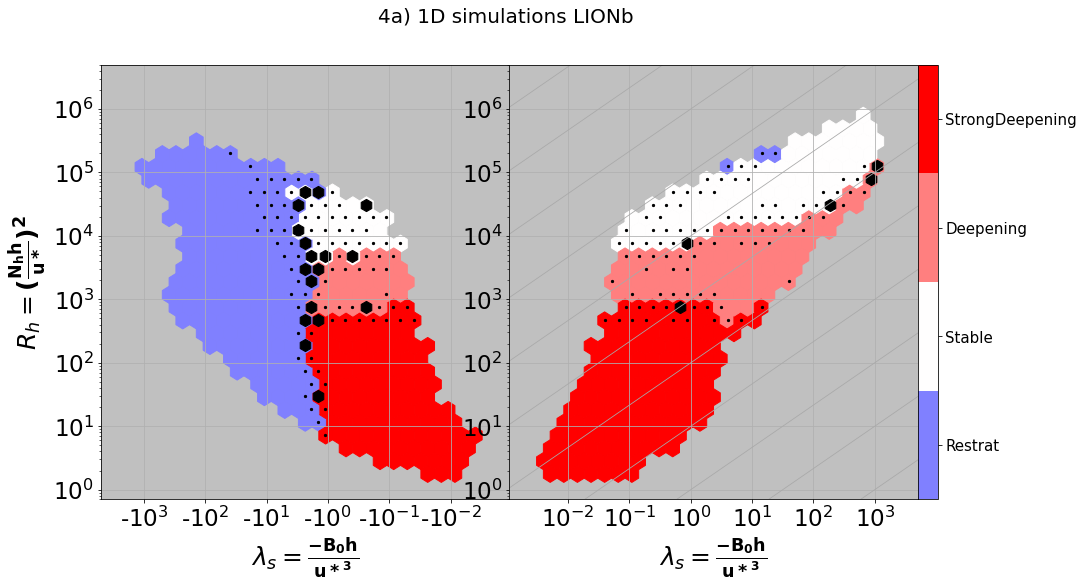

In [6]:
### 4a) 1D simulations LIONb 

### For loading 1D simus LIONb data
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"4a) 1D simulations LIONb", fontsize = 20)


NotSignif : 4.9%
Signif : 42%
HighSignif : 53%


Text(0.5, 0.98, '4b) 1D simulations LABs')

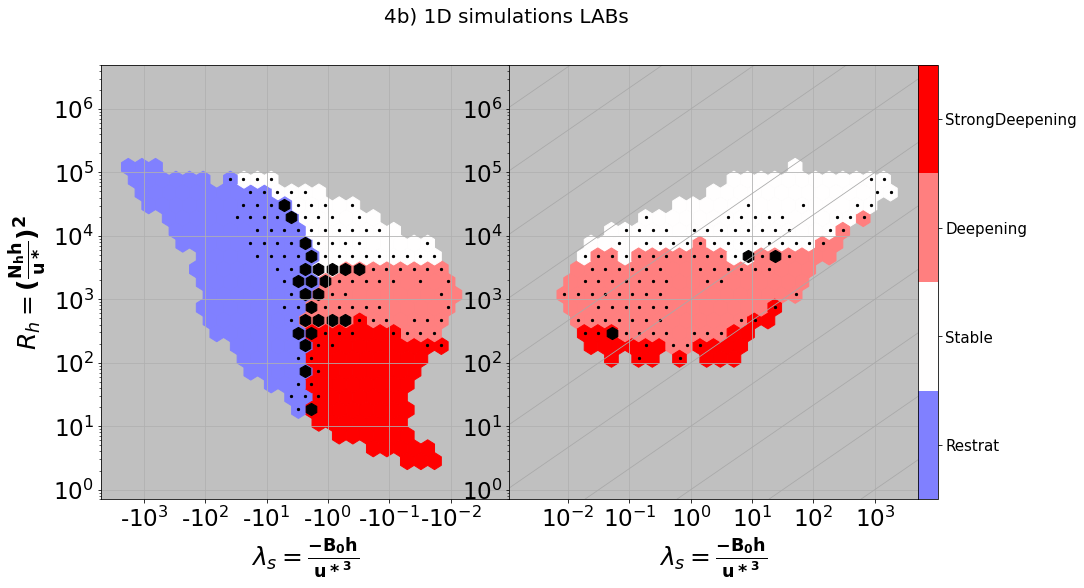

In [7]:
### 4b) 1D simulations LABs 

### For loading 1D simus LABs data
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"4b) 1D simulations LABs", fontsize = 20)


NotSignif : 3.2%
Signif : 36%
HighSignif : 61%


Text(0.5, 0.98, '4c) 1D simulations LIONb + LABs')

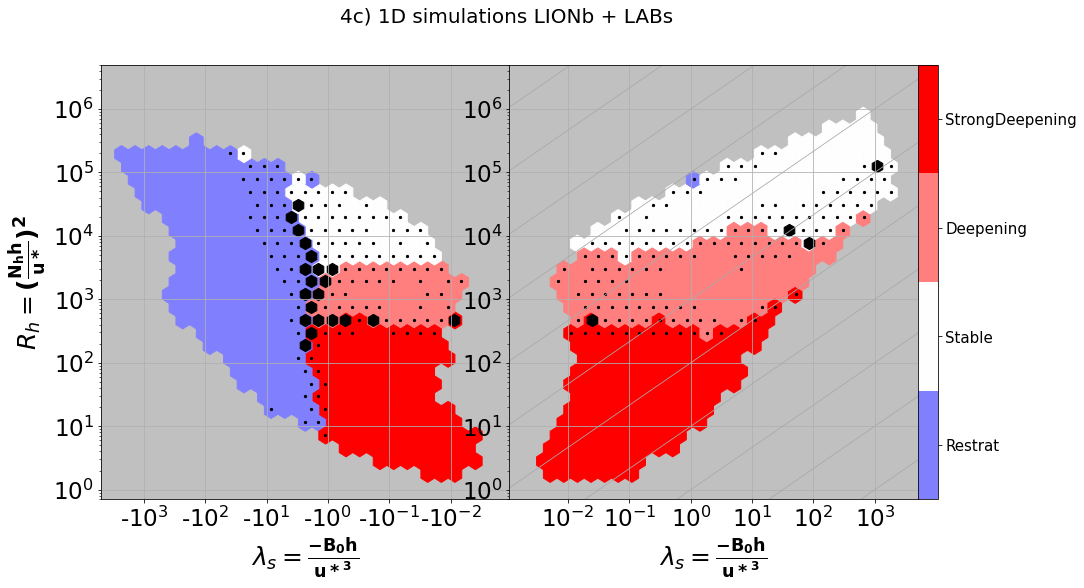

In [8]:
### 4c) 1D simulations LIONb + LABs 

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LIONb = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LIONb  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LIONb   = data['lambdas_1Dmodels']
Rh_1Dmodels_LIONb        = data['Rh_1Dmodels']

filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LABs = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LABs  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LABs   = data['lambdas_1Dmodels']
Rh_1Dmodels_LABs        = data['Rh_1Dmodels']

dMLDdt_1Dmodels_ps      = np.concatenate((dMLDdt_1Dmodels_ps_LIONb,dMLDdt_1Dmodels_ps_LABs))
MLD_1Dmodels_b_ps       = np.concatenate((MLD_1Dmodels_b_ps_LIONb,MLD_1Dmodels_b_ps_LABs))
lambdas_1Dmodels        = np.concatenate((lambdas_1Dmodels_LIONb,lambdas_1Dmodels_LABs))
Rh_1Dmodels             = np.concatenate((Rh_1Dmodels_LIONb,Rh_1Dmodels_LABs))
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"4c) 1D simulations LIONb + LABs", fontsize = 20)


### Figure 5

NotSignif : 3.2%
Signif : 36%
HighSignif : 61%


Text(0.5, 0.98, '5a) 1D simulations LIONb + LABs')

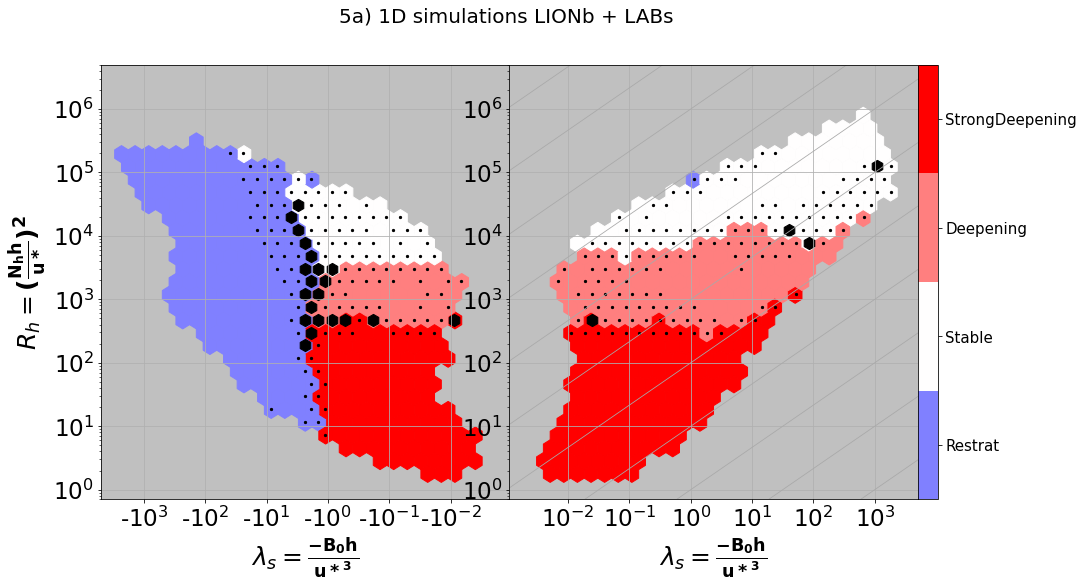

In [9]:
### 5a) 1D simulations LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LIONb = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LIONb  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LIONb   = data['lambdas_1Dmodels']
Rh_1Dmodels_LIONb        = data['Rh_1Dmodels']

filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LABs = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LABs  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LABs   = data['lambdas_1Dmodels']
Rh_1Dmodels_LABs        = data['Rh_1Dmodels']

dMLDdt_1Dmodels_ps      = np.concatenate((dMLDdt_1Dmodels_ps_LIONb,dMLDdt_1Dmodels_ps_LABs))
MLD_1Dmodels_b_ps       = np.concatenate((MLD_1Dmodels_b_ps_LIONb,MLD_1Dmodels_b_ps_LABs))
lambdas_1Dmodels        = np.concatenate((lambdas_1Dmodels_LIONb,lambdas_1Dmodels_LABs))
Rh_1Dmodels             = np.concatenate((Rh_1Dmodels_LIONb,Rh_1Dmodels_LABs))
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"5a) 1D simulations LIONb + LABs", fontsize = 20)


NotSignif : 13%
Signif : 49%
HighSignif : 38%


Text(0.5, 0.98, '5b) eORCA1 LIONb + LABs')

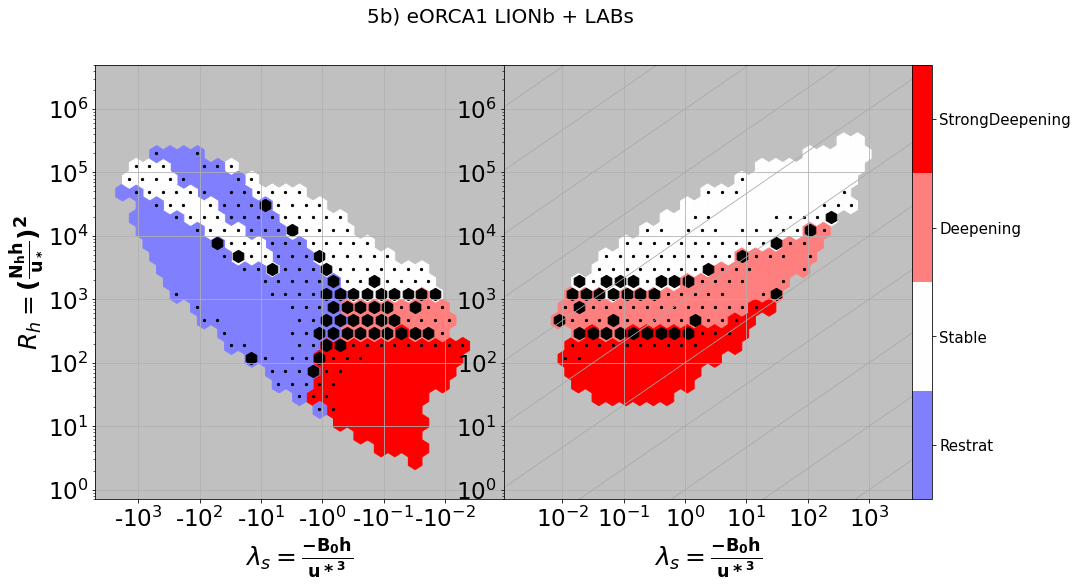

In [10]:
### 5b) eORCA1 LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps_LIONb  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps_LIONb   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1_LIONb    = data['lambdas_eORCA1']
Rh_eORCA1_LIONb         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps_LIONb = 100*dMLDdt_eORCA1_ps_LIONb/(MLD_eORCA1_b_ps_LIONb)*3600*24   # [%/day]

filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps_LABs  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps_LABs   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1_LABs    = data['lambdas_eORCA1']
Rh_eORCA1_LABs         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps_LABs = 100*dMLDdt_eORCA1_ps_LABs/(MLD_eORCA1_b_ps_LABs)*3600*24   # [%/day]

dMLDdt_eORCA1_ps      = np.concatenate((dMLDdt_eORCA1_ps_LIONb,dMLDdt_eORCA1_ps_LABs))
MLD_eORCA1_b_ps       = np.concatenate((MLD_eORCA1_b_ps_LIONb,MLD_eORCA1_b_ps_LABs))
lambdas_eORCA1        = np.concatenate((lambdas_eORCA1_LIONb,lambdas_eORCA1_LABs))
Rh_eORCA1             = np.concatenate((Rh_eORCA1_LIONb,Rh_eORCA1_LABs))
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"5b) eORCA1 LIONb + LABs", fontsize = 20)


NotSignif : 29%
Signif : 21%
HighSignif : 50%


Text(0.5, 0.98, '5c) ORCA12 LIONb + LABs')

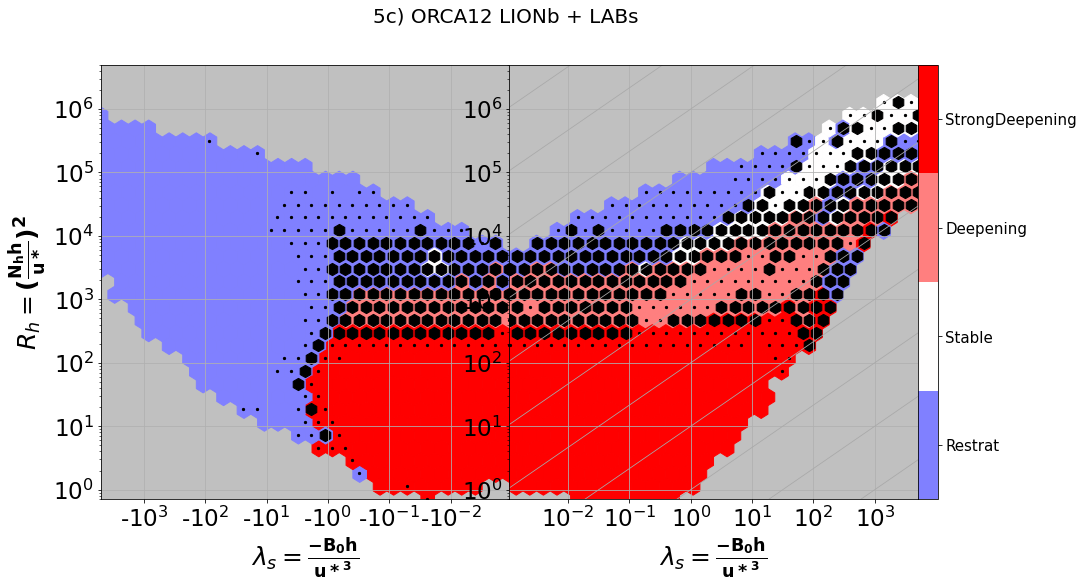

In [11]:
### 5c) ORCA12 LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + 'ORCA12_y2006-2015_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_ORCA12_ps_LIONb  = data['dMLDdt_ORCA12_ps']
MLD_ORCA12_b_ps_LIONb   = data['MLD_ORCA12_b_ps']
lambdas_ORCA12_LIONb    = data['lambdas_ORCA12']
Rh_ORCA12_LIONb         = data['Rh_ORCA12']
dMLDdt_percent_ORCA12_ps_LIONb = 100*dMLDdt_ORCA12_ps_LIONb/(MLD_ORCA12_b_ps_LIONb)*3600*24   # [%/day]

filename = path_to_npz_archives + 'ORCA12_y2006-2015_LABs_ps.npz'
data = np.load(filename)
dMLDdt_ORCA12_ps_LABs  = data['dMLDdt_ORCA12_ps']
MLD_ORCA12_b_ps_LABs   = data['MLD_ORCA12_b_ps']
lambdas_ORCA12_LABs    = data['lambdas_ORCA12']
Rh_ORCA12_LABs         = data['Rh_ORCA12']
dMLDdt_percent_ORCA12_ps_LABs = 100*dMLDdt_ORCA12_ps_LABs/(MLD_ORCA12_b_ps_LABs)*3600*24   # [%/day]

dMLDdt_ORCA12_ps      = np.concatenate((dMLDdt_ORCA12_ps_LIONb,dMLDdt_ORCA12_ps_LABs))
MLD_ORCA12_b_ps       = np.concatenate((MLD_ORCA12_b_ps_LIONb,MLD_ORCA12_b_ps_LABs))
lambdas_ORCA12        = np.concatenate((lambdas_ORCA12_LIONb,lambdas_ORCA12_LABs))
Rh_ORCA12             = np.concatenate((Rh_ORCA12_LIONb,Rh_ORCA12_LABs))
dMLDdt_percent_ORCA12_ps = 100*dMLDdt_ORCA12_ps/(MLD_ORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_ORCA12
y_array = Rh_ORCA12
my_var  = dMLDdt_percent_ORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"5c) ORCA12 LIONb + LABs", fontsize = 20)


NotSignif : 32%
Signif : 22%
HighSignif : 46%


Text(0.5, 0.98, '5d) eNATL60 LIONb + LABs')

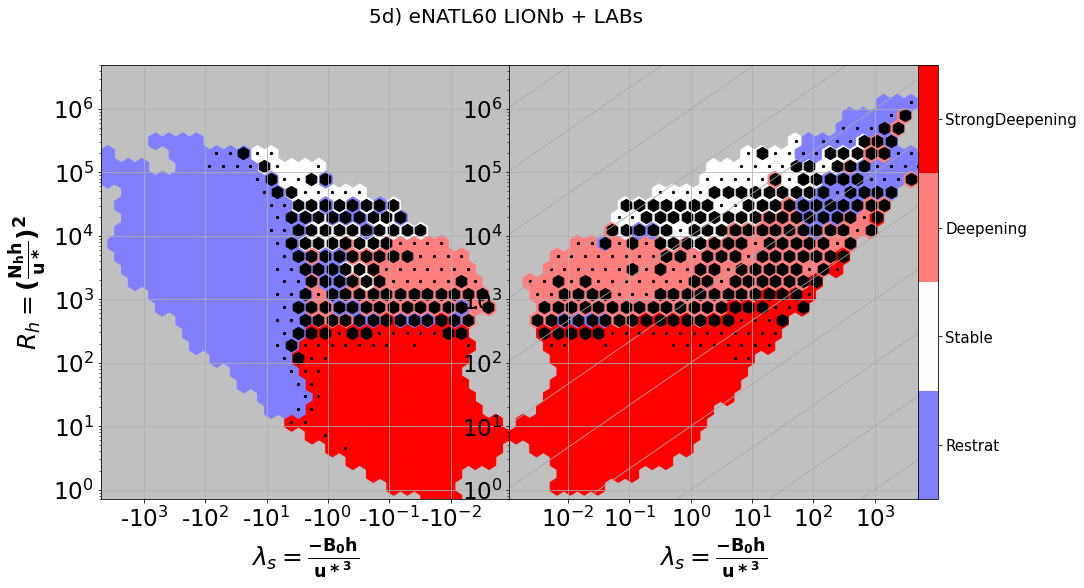

In [12]:
### 5d) eNATL60 LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps_LIONb  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps_LIONb   = data['MLD_eNATL60_b_ps']
lambdas_eNATL60_LIONb    = data['lambdas_eNATL60']
Rh_eNATL60_LIONb         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps_LIONb = 100*dMLDdt_eNATL60_ps_LIONb/(MLD_eNATL60_b_ps_LIONb)*3600*24   # [%/day]

filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps_LABs  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps_LABs   = data['MLD_eNATL60_b_ps']
lambdas_eNATL60_LABs    = data['lambdas_eNATL60']
Rh_eNATL60_LABs         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps_LABs = 100*dMLDdt_eNATL60_ps_LABs/(MLD_eNATL60_b_ps_LABs)*3600*24   # [%/day]

dMLDdt_eNATL60_ps      = np.concatenate((dMLDdt_eNATL60_ps_LIONb,dMLDdt_eNATL60_ps_LABs))
MLD_eNATL60_b_ps       = np.concatenate((MLD_eNATL60_b_ps_LIONb,MLD_eNATL60_b_ps_LABs))
lambdas_eNATL60        = np.concatenate((lambdas_eNATL60_LIONb,lambdas_eNATL60_LABs))
Rh_eNATL60             = np.concatenate((Rh_eNATL60_LIONb,Rh_eNATL60_LABs))
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"5d) eNATL60 LIONb + LABs", fontsize = 20)


### Figure 6

NotSignif : 13%
Signif : 48%
HighSignif : 39%


Text(0.5, 0.98, '6a) eORCA1 LIONb')

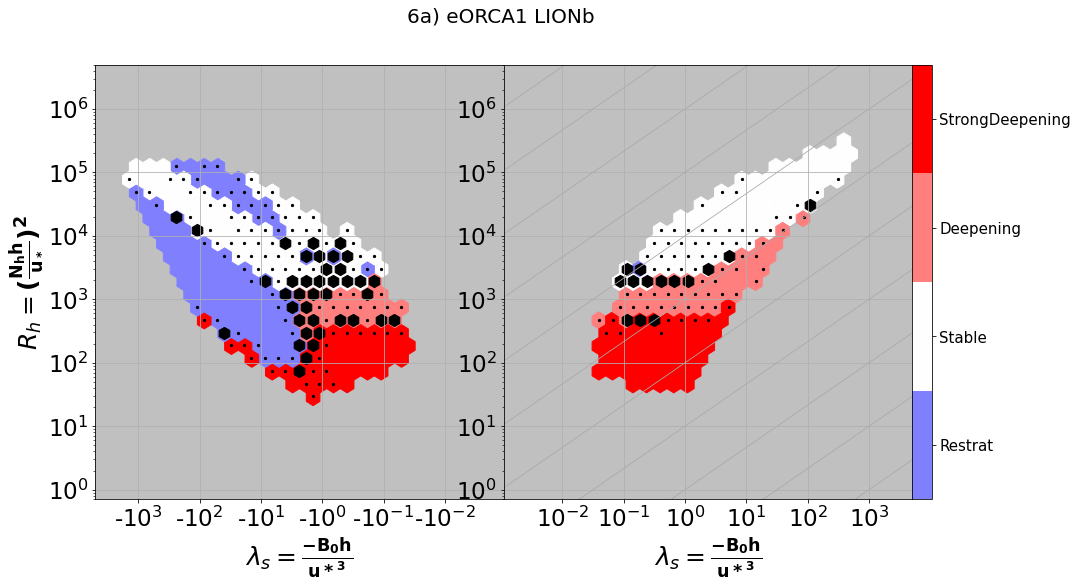

In [13]:
### 6a) eORCA1 LIONb 

#### For loading eORCA1 LIONb data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6a) eORCA1 LIONb", fontsize = 20)


NotSignif : 15%
Signif : 46%
HighSignif : 39%


Text(0.5, 0.98, '6b) eORCA1GM LIONb')

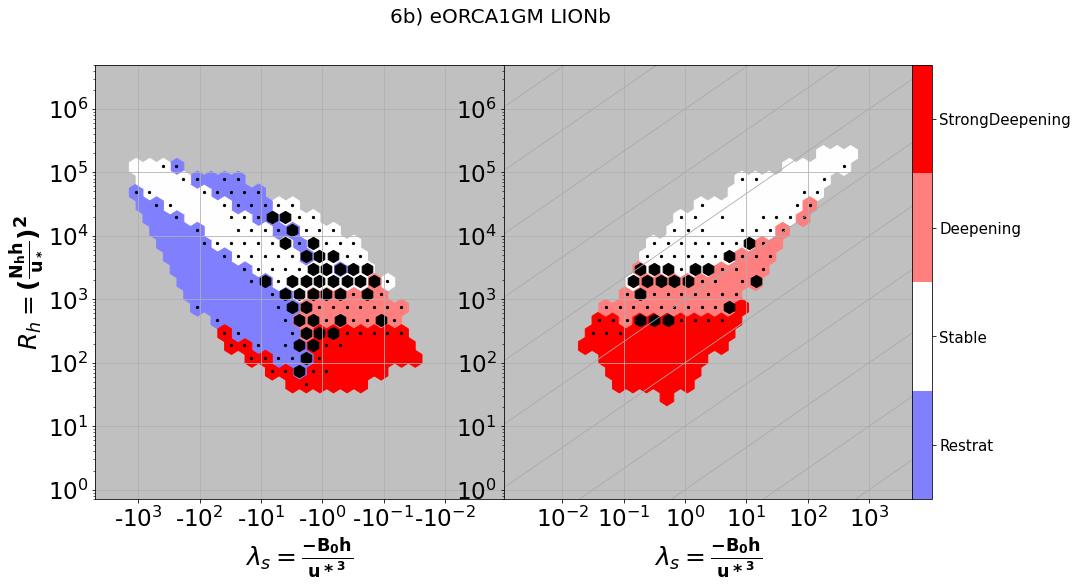

In [14]:
### 6b) eORCA1GM LIONb 

#### For loading eORCA1GM LIONb data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6b) eORCA1GM LIONb", fontsize = 20)


NotSignif : 23%
Signif : 23%
HighSignif : 54%


Text(0.5, 0.98, '6c) eNATL60 LIONb')

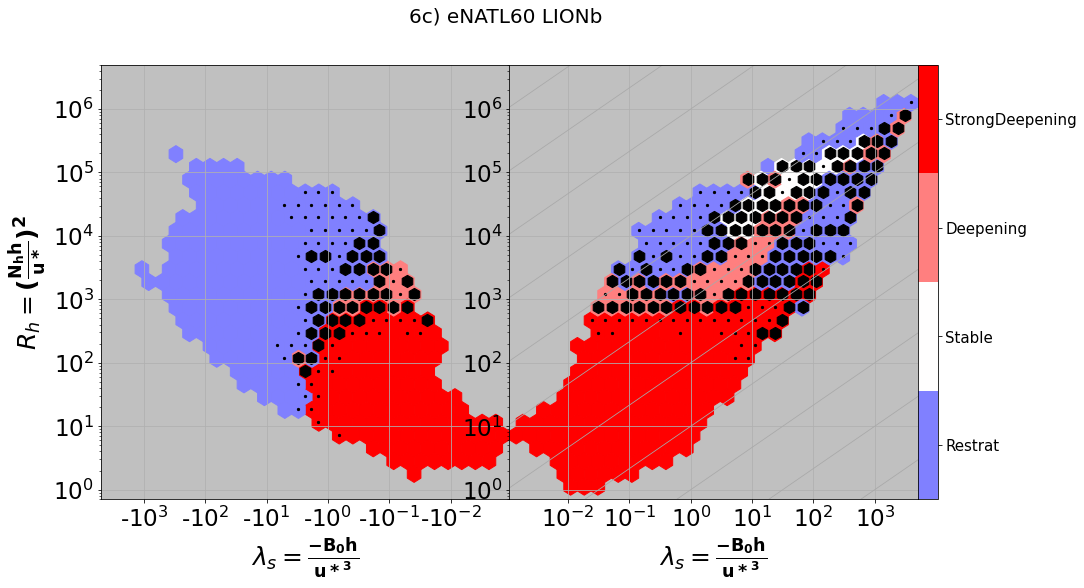

In [15]:
### 6c) eNATL60 LIONb 

### For loading eNATL60 LIONb data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6c) eNATL60 LIONb", fontsize = 20)


NotSignif : 13%
Signif : 39%
HighSignif : 48%


Text(0.5, 0.98, '6d) eORCA1 LABs')

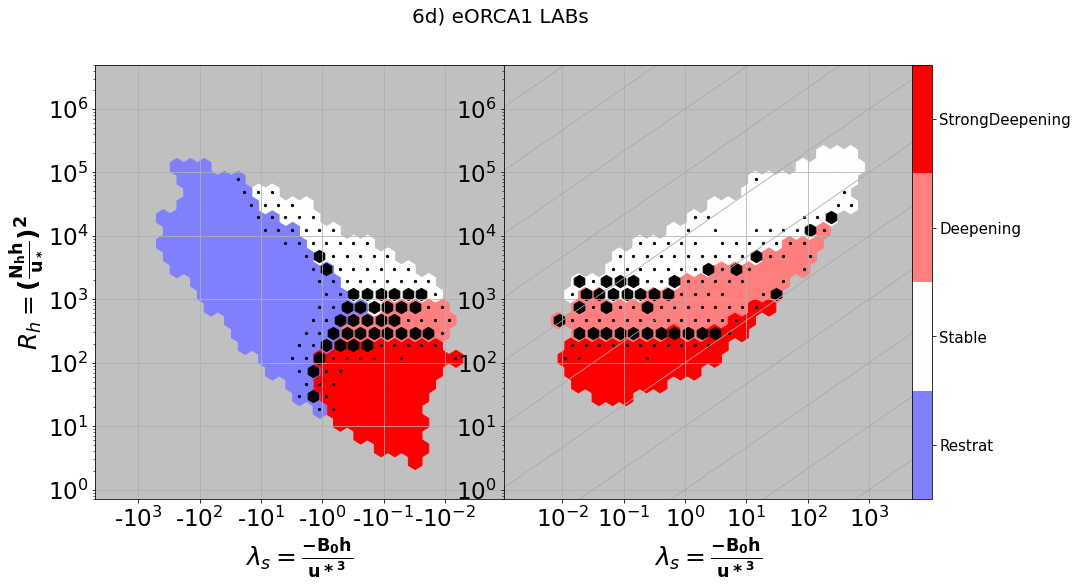

In [16]:
### 6d) eORCA1 LABs 

#### For loading eORCA1 LABs data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6d) eORCA1 LABs", fontsize = 20)


NotSignif : 21%
Signif : 33%
HighSignif : 46%


Text(0.5, 0.98, '6e) eORCA1GM LABs')

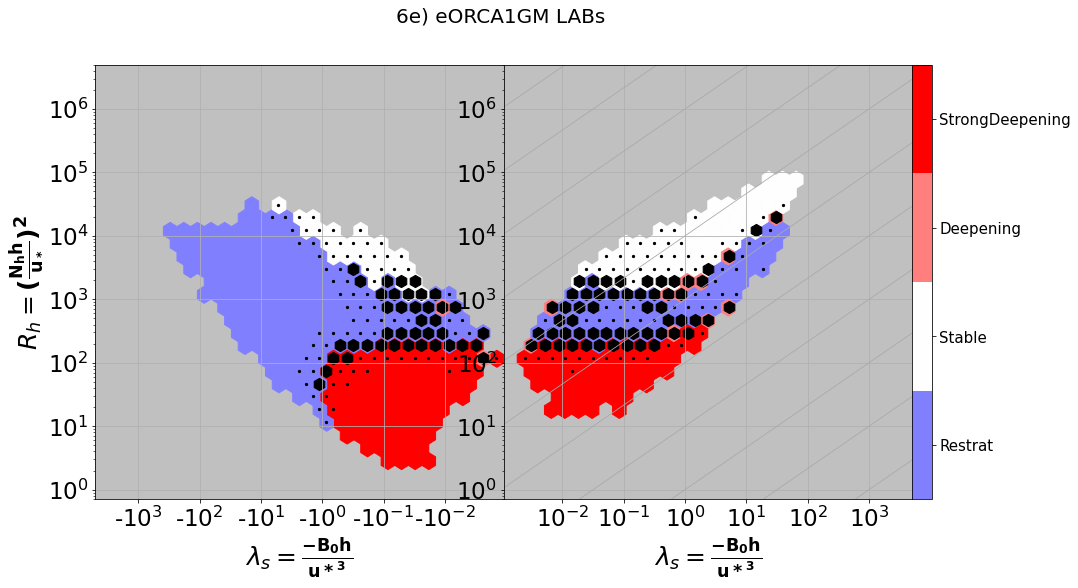

In [17]:
### 6e) eORCA1GM LABs 

#### For loading eORCA1GM LABs data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6e) eORCA1GM LABs", fontsize = 20)


NotSignif : 34%
Signif : 29%
HighSignif : 37%


Text(0.5, 0.98, '6f) eNATL60 LABs')

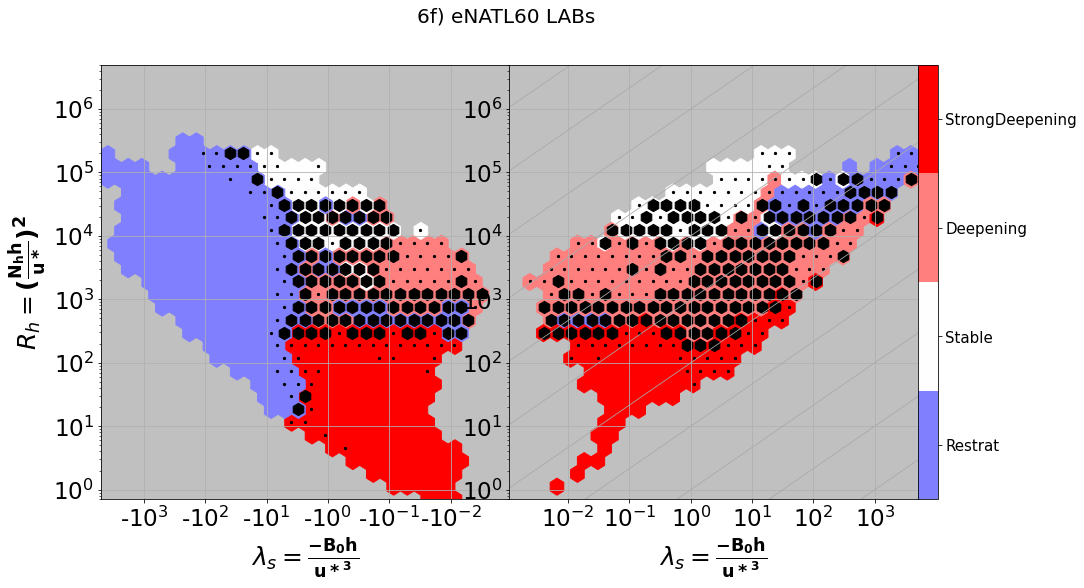

In [18]:
### 6f) eNATL60 LABs 

### For loading eNATL60 LABs data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6f) eNATL60 LABs", fontsize = 20)


### Figure 7

In [19]:
####   Calculation Proxy_GM LIONb for eORCA1GM  ###
### ---------------------------------------- ###

#R_earth = 6373.0 * 1000     # earth radius [m]
#
#nav_lon_eORCA1GM = gridT_eORCA1GM.nav_lon
#nav_lat_eORCA1GM = gridT_eORCA1GM.nav_lat
#
#dlon_left = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = 1))
#dlat_left = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = 1))
#a_left = np.sin(dlat_left / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_left / 2)**2
#c_left = 2 * np.arctan2(np.sqrt(a_left), np.sqrt(1 - a_left))
#distance_left = R_earth * c_left
#
#dlon_right = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = -1))
#dlat_right = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = -1))
#a_right = np.sin(dlat_right / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_right / 2)**2
#c_right = 2 * np.arctan2(np.sqrt(a_right), np.sqrt(1 - a_right))
#distance_right = R_earth * c_right
#
#dlon_down = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = 1))
#dlat_down = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = 1))
#a_down = np.sin(dlat_down / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_down / 2)**2
#c_down = 2 * np.arctan2(np.sqrt(a_down), np.sqrt(1 - a_down))
#distance_down = R_earth * c_down
#
#dlon_up = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = -1))
#dlat_up = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = -1))
#a_up = np.sin(dlat_up / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_up / 2)**2
#c_up = 2 * np.arctan2(np.sqrt(a_up), np.sqrt(1 - a_up))
#distance_up = R_earth * c_up
#
#
#drhodx_left = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = 1))  /  distance_left
#drhodx_right = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = -1))  /  distance_right
#drhody_down = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = 1))  /  distance_down
#drhody_up = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = -1))  /  distance_up
#
#dz_partialz = 1.1 * MLD_eORCA1GM_b - 1 * MLD_eORCA1GM_b
#drhodz = (temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]) / dz_partialz
#
##proxy_GM_eORCA1GM_b = np.sqrt(1/4*(drhodx_left**2 + drhodx_right**2 + drhody_down**2 + drhody_up**2)/drhodz**2)
#drhodlateral_square_max_temp = np.maximum(drhodx_left**2,drhodx_right**2)
#drhodlateral_square_max_temp = np.maximum(drhodlateral_square_max_temp,drhody_down**2)
#drhodlateral_square_max = np.maximum(drhodlateral_square_max_temp,drhody_up**2)
#proxy_GM_eORCA1GM_b = np.sqrt(drhodlateral_square_max / drhodz**2)
#
##plt.contourf(proxy_GM_eORCA1GM_b.mean(('time_counter')))
##plt.colorbar()
##
##plt.figure()
##plt.plot(proxy_GM_eORCA1GM_b.mean(('x','y')))
#
#DeltaRho_eORCA1GM_b_flat = DeltaRho_eORCA1GM_b.values.flatten()
#bathy_eORCA1GM_flat  = bathy_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]}).values.flatten()
#mask_eORCA1GM_flat   = (bathy_eORCA1GM_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
#mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (DeltaRho_eORCA1GM_b_flat > 0)
#
#proxy_GM_eORCA1GM_b_flat = proxy_GM_eORCA1GM_b.values.flatten()
#proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_flat[mask_eORCA1GM_flat]


In [20]:
####   Calculation Proxy_GM LABs for eORCA1GM  ###
### ---------------------------------------- ###

#R_earth = 6373.0 * 1000     # earth radius [m]
#
#nav_lon_eORCA1GM = gridT_eORCA1GM.nav_lon
#nav_lat_eORCA1GM = gridT_eORCA1GM.nav_lat
#
#dlon_left = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = 1))
#dlat_left = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = 1))
#a_left = np.sin(dlat_left / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_left / 2)**2
#c_left = 2 * np.arctan2(np.sqrt(a_left), np.sqrt(1 - a_left))
#distance_left = R_earth * c_left
#
#dlon_right = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = -1))
#dlat_right = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = -1))
#a_right = np.sin(dlat_right / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_right / 2)**2
#c_right = 2 * np.arctan2(np.sqrt(a_right), np.sqrt(1 - a_right))
#distance_right = R_earth * c_right
#
#dlon_down = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = 1))
#dlat_down = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = 1))
#a_down = np.sin(dlat_down / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_down / 2)**2
#c_down = 2 * np.arctan2(np.sqrt(a_down), np.sqrt(1 - a_down))
#distance_down = R_earth * c_down
#
#dlon_up = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = -1))
#dlat_up = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = -1))
#a_up = np.sin(dlat_up / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_up / 2)**2
#c_up = 2 * np.arctan2(np.sqrt(a_up), np.sqrt(1 - a_up))
#distance_up = R_earth * c_up
#
#
#drhodx_left = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = 1))  /  distance_left
#drhodx_right = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = -1))  /  distance_right
#drhody_down = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = 1))  /  distance_down
#drhody_up = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = -1))  /  distance_up
#
#dz_partialz = 1.1 * MLD_eORCA1GM_b - 1 * MLD_eORCA1GM_b
#drhodz = (temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]) / dz_partialz
#
##proxy_GM_eORCA1GM_b = np.sqrt(1/4*(drhodx_left**2 + drhodx_right**2 + drhody_down**2 + drhody_up**2)/drhodz**2)
#drhodlateral_square_max_temp = np.maximum(drhodx_left**2,drhodx_right**2)
#drhodlateral_square_max_temp = np.maximum(drhodlateral_square_max_temp,drhody_down**2)
#drhodlateral_square_max = np.maximum(drhodlateral_square_max_temp,drhody_up**2)
#proxy_GM_eORCA1GM_b = np.sqrt(drhodlateral_square_max / drhodz**2)
#
##plt.contourf(proxy_GM_eORCA1GM_b.mean(('time_counter')))
##plt.colorbar()
##
##plt.figure()
##plt.plot(proxy_GM_eORCA1GM_b.mean(('x','y')))
#
#
#DeltaRho_eORCA1GM_b_flat = DeltaRho_eORCA1GM_b.values.flatten()
#bathy_eORCA1GM_flat  = bathy_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]}).values.flatten()
#mask_eORCA1GM_flat   = (bathy_eORCA1GM_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
#mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (DeltaRho_eORCA1GM_b_flat > 0)
#
#proxy_GM_eORCA1GM_b_flat = proxy_GM_eORCA1GM_b.values.flatten()
#proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_flat[mask_eORCA1GM_flat]


Text(0.5, 0.98, '7a) Index GM LIONb (eORCA1GM)')

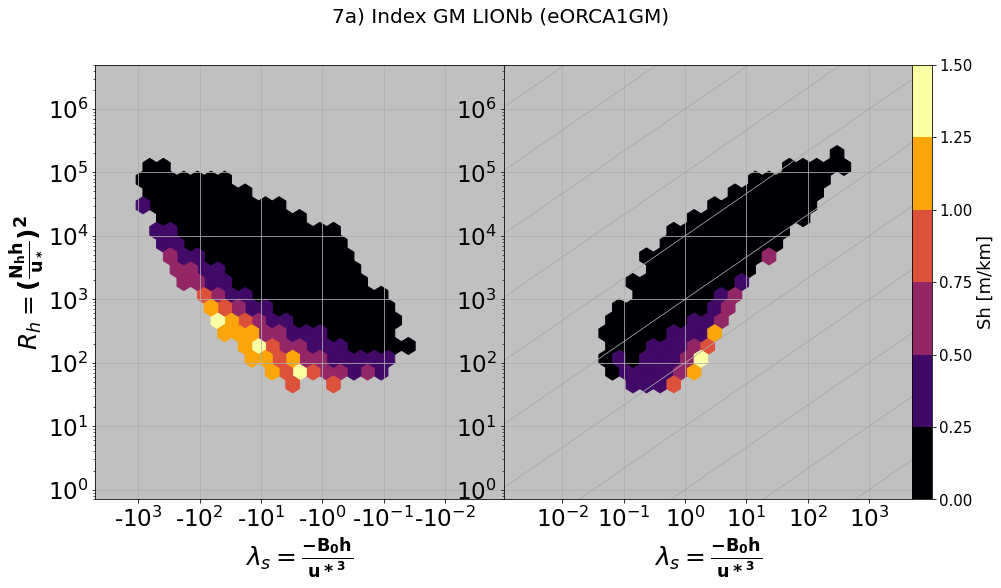

In [21]:
### 7a) eORCA1GM LIONb ProxyGM 

#### For loading LIONb eORCA1GM data
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LIONb proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LIONb_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']


#### -------------------------------- ###
####          HEXBIN PLOT             ###
#### -------------------------------- ###


### Variables that can be plotted
### -----------------------------
### dMLDdt_percent (dMLDdt/MLD)    dMLDdt_percent_classes    Shmax

vmin = 0*1000
vmax = 0.0015*1000
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6

my_norm = None
my_var = proxy_GM_eORCA1GM_b_ps*1000
my_clabel = 'Sh [m/km]'
my_cmap = 'inferno'
my_reduce_C_function = np.mean  # Function used to agregate in the bins. Default = mean

### --------------------------------
### Main plot (by personal function)
### --------------------------------

mincnt = 29     # only the hexagons with more than mincrt points are displayed

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(lambdas_eORCA1GM,Rh_eORCA1GM,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=my_norm,vmin=vmin,vmax=vmax,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel=my_clabel,cmap=my_cmap,mincnt=mincnt)
                        
    
### -----------------------------------------------------
### Adding important straight lines and texts on the plot
### -----------------------------------------------------

print('') ; ax0.grid() ; ax1.grid() ;

n_colors = 6
my_cmap = matplotlib.cm.get_cmap(my_cmap)  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, n_colors)
my_cmap.set_over('r')
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5],major=True);

additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

plt.suptitle(f"7a) Index GM LIONb (eORCA1GM)", fontsize = 20)


NotSignif : 15%
Signif : 46%
HighSignif : 39%


Text(0.5, 0.98, '7b) eORCA1GM LIONb')

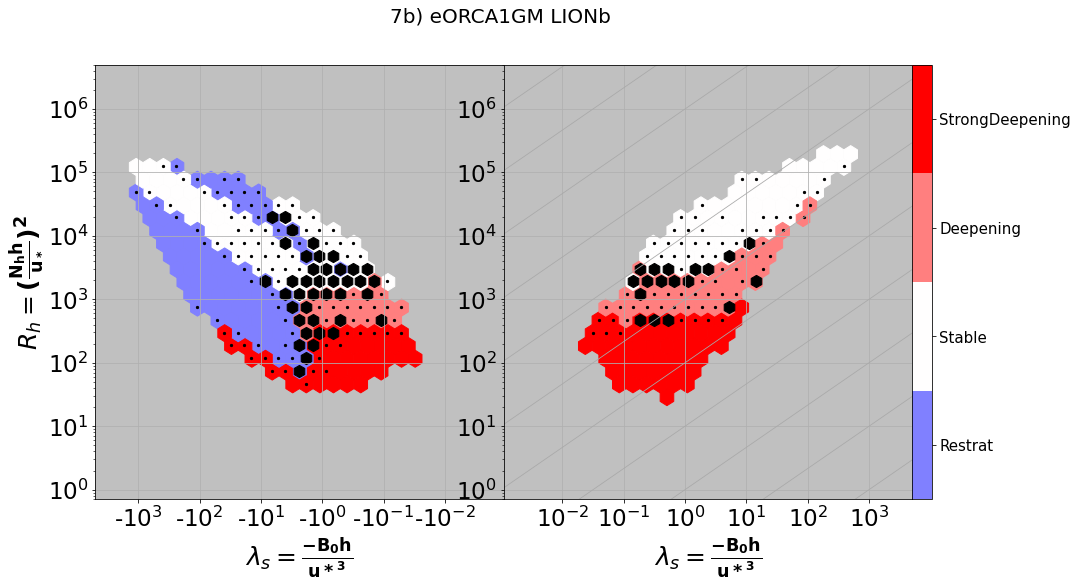

In [22]:
### 7b) eORCA1GM LIONb 

#### For loading eORCA1GM LIONb data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7b) eORCA1GM LIONb", fontsize = 20)


NotSignif : 14%
Signif : 46%
HighSignif : 39%


Text(0.5, 0.98, '7c) eORCA1GM LIONb restricted to Sh < 0.5m/km')

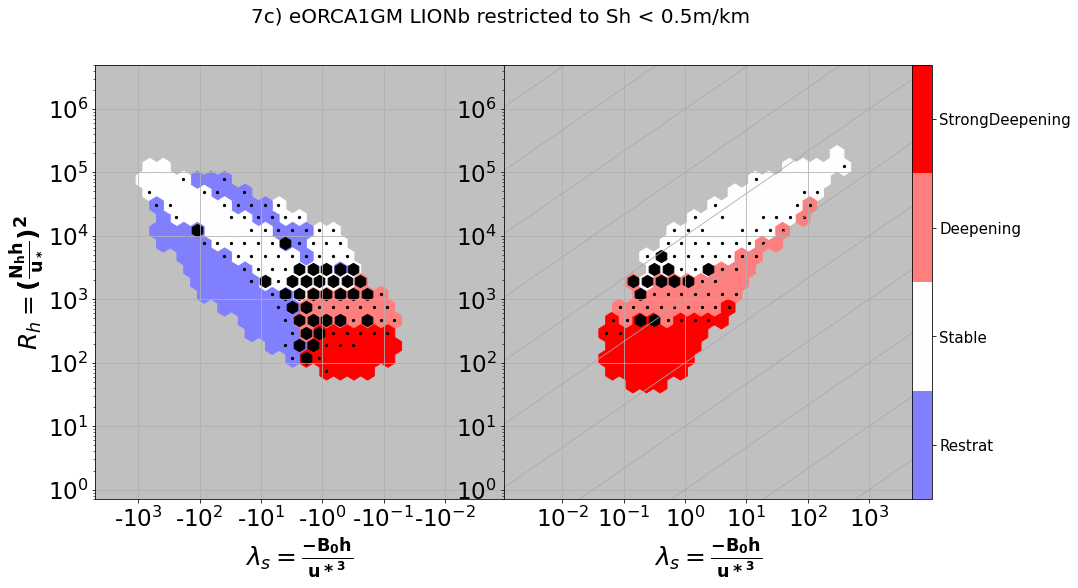

In [23]:
### 7c) eORCA1GM LIONb restricted to Sh < 0.5m/km

#### For loading eORCA1GM LIONb data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
ustar_eORCA1GM_ps   = data['ustar_eORCA1GM_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LIONb proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LIONb_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']

### For restricting to Shmax < 0.5m/km
mask_eORCA1GM_flat   = np.copy(ustar_eORCA1GM_ps > 0)
mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (proxy_GM_eORCA1GM_b_ps < 0.0005)
lambdas_eORCA1GM       = lambdas_eORCA1GM[mask_eORCA1GM_flat]
Rh_eORCA1GM            = Rh_eORCA1GM[mask_eORCA1GM_flat]
dMLDdt_eORCA1GM_ps     = dMLDdt_eORCA1GM_ps[mask_eORCA1GM_flat]
MLD_eORCA1GM_b_ps      = MLD_eORCA1GM_b_ps[mask_eORCA1GM_flat]
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]
proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_ps[mask_eORCA1GM_flat]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7c) eORCA1GM LIONb restricted to Sh < 0.5m/km", fontsize = 20)


NotSignif : 13%
Signif : 48%
HighSignif : 39%


Text(0.5, 0.98, '7d) eORCA1 LIONb')

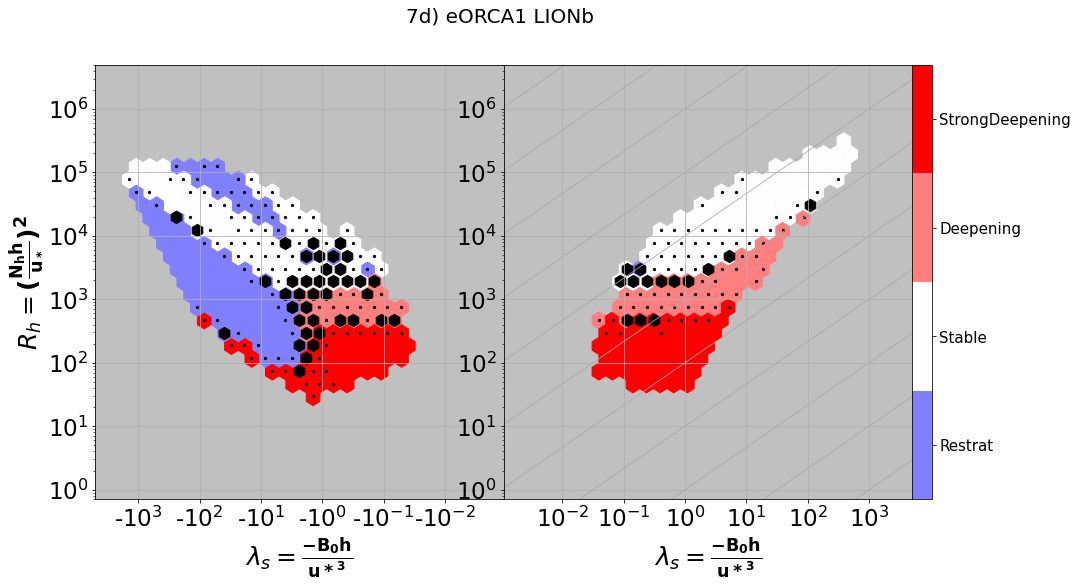

In [24]:
### 7d) eORCA1 LIONb 

#### For loading eORCA1 LIONb data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7d) eORCA1 LIONb", fontsize = 20)


Text(0.5, 0.98, '7e) Index GM LABs (eORCA1GM)')

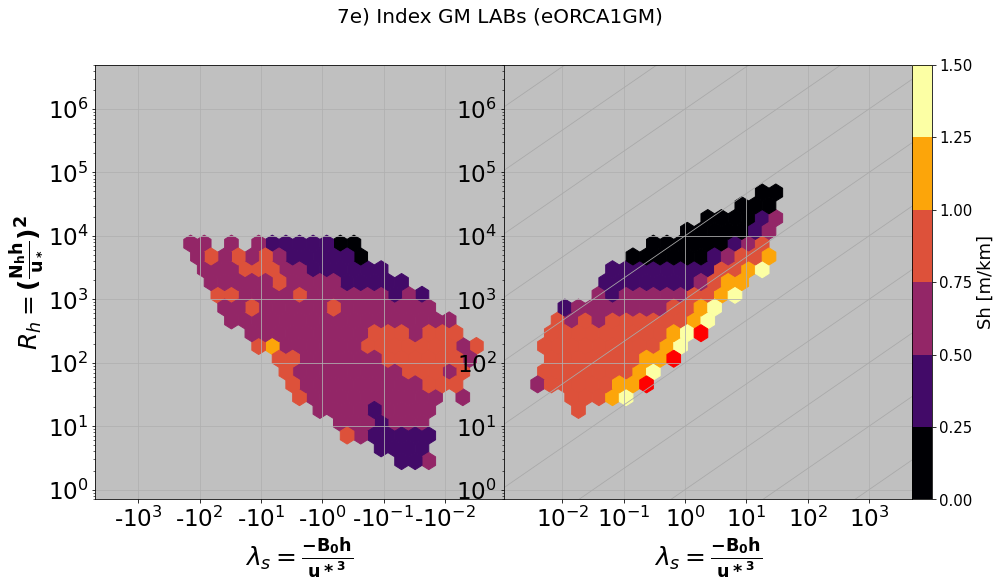

In [25]:
### 7e) eORCA1GM LABs ProxyGM 

#### For loading LABs eORCA1GM data
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LABs proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LABs_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']


#### -------------------------------- ###
####          HEXBIN PLOT             ###
#### -------------------------------- ###


### Variables that can be plotted
### -----------------------------
### dMLDdt_percent (dMLDdt/MLD)    dMLDdt_percent_classes    Shmax

vmin = 0*1000
vmax = 0.0015*1000
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6

my_norm = None
my_var = proxy_GM_eORCA1GM_b_ps*1000
my_clabel = 'Sh [m/km]'
my_cmap = 'inferno'
my_reduce_C_function = np.mean  # Function used to agregate in the bins. Default = mean

### --------------------------------
### Main plot (by personal function)
### --------------------------------

mincnt = 29     # only the hexagons with more than mincrt points are displayed

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(lambdas_eORCA1GM,Rh_eORCA1GM,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=my_norm,vmin=vmin,vmax=vmax,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel=my_clabel,cmap=my_cmap,mincnt=mincnt)
                        
    
### -----------------------------------------------------
### Adding important straight lines and texts on the plot
### -----------------------------------------------------

print('') ; ax0.grid() ; ax1.grid() ;

n_colors = 6
my_cmap = matplotlib.cm.get_cmap(my_cmap)  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, n_colors)
my_cmap.set_over('r')
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5],major=True);

additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

plt.suptitle(f"7e) Index GM LABs (eORCA1GM)", fontsize = 20)


NotSignif : 21%
Signif : 33%
HighSignif : 46%


Text(0.5, 0.98, '7f) eORCA1GM LABs')

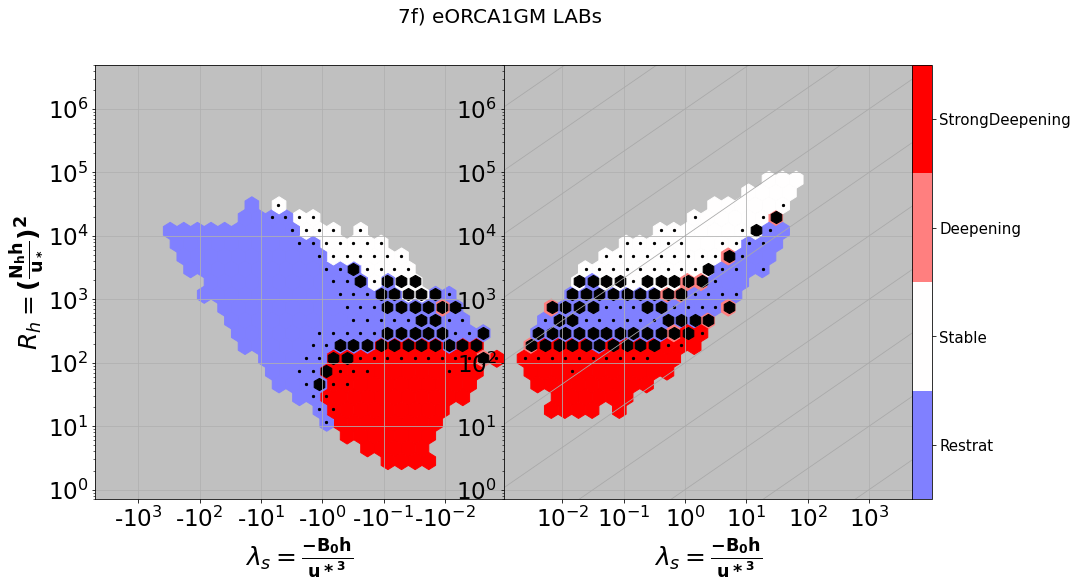

In [26]:
### 7f) eORCA1GM LABs 

#### For loading eORCA1GM LABs data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7f) eORCA1GM LABs", fontsize = 20)


NotSignif : 18%
Signif : 37%
HighSignif : 45%


Text(0.5, 0.98, '7g) eORCA1GM LABs restricted to Sh < 0.5m/km')

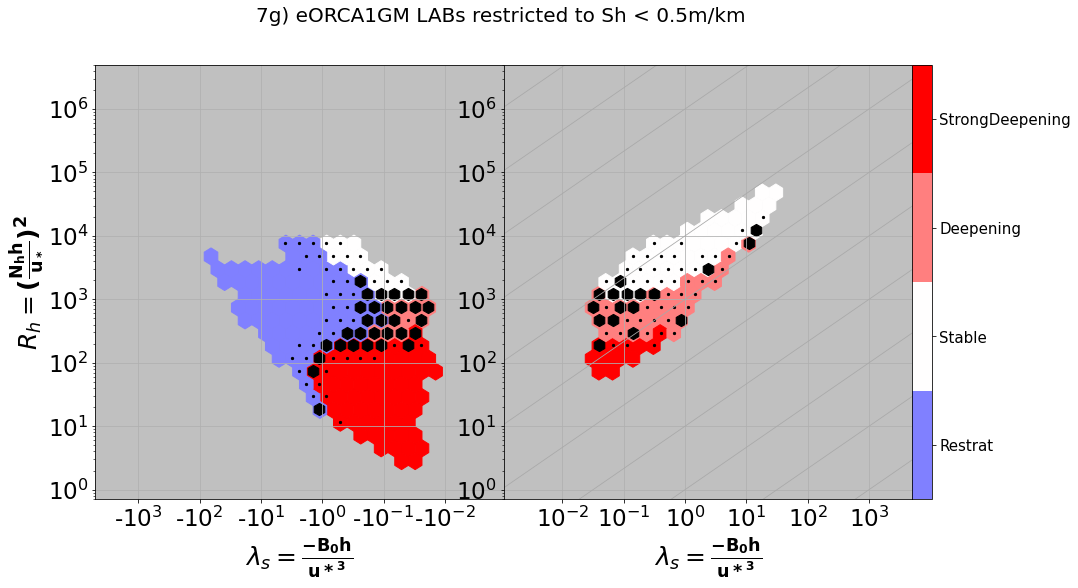

In [27]:
### 7g) eORCA1GM LABs restricted to Sh < 0.5m/km

#### For loading eORCA1GM LABs data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
ustar_eORCA1GM_ps   = data['ustar_eORCA1GM_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LABs proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LABs_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']

### For restricting to Shmax < 0.5m/km
mask_eORCA1GM_flat   = np.copy(ustar_eORCA1GM_ps > 0)
mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (proxy_GM_eORCA1GM_b_ps < 0.0005)
lambdas_eORCA1GM       = lambdas_eORCA1GM[mask_eORCA1GM_flat]
Rh_eORCA1GM            = Rh_eORCA1GM[mask_eORCA1GM_flat]
dMLDdt_eORCA1GM_ps     = dMLDdt_eORCA1GM_ps[mask_eORCA1GM_flat]
MLD_eORCA1GM_b_ps      = MLD_eORCA1GM_b_ps[mask_eORCA1GM_flat]
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]
proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_ps[mask_eORCA1GM_flat]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7g) eORCA1GM LABs restricted to Sh < 0.5m/km", fontsize = 20)


NotSignif : 13%
Signif : 39%
HighSignif : 48%


Text(0.5, 0.98, '7h) eORCA1 LABs')

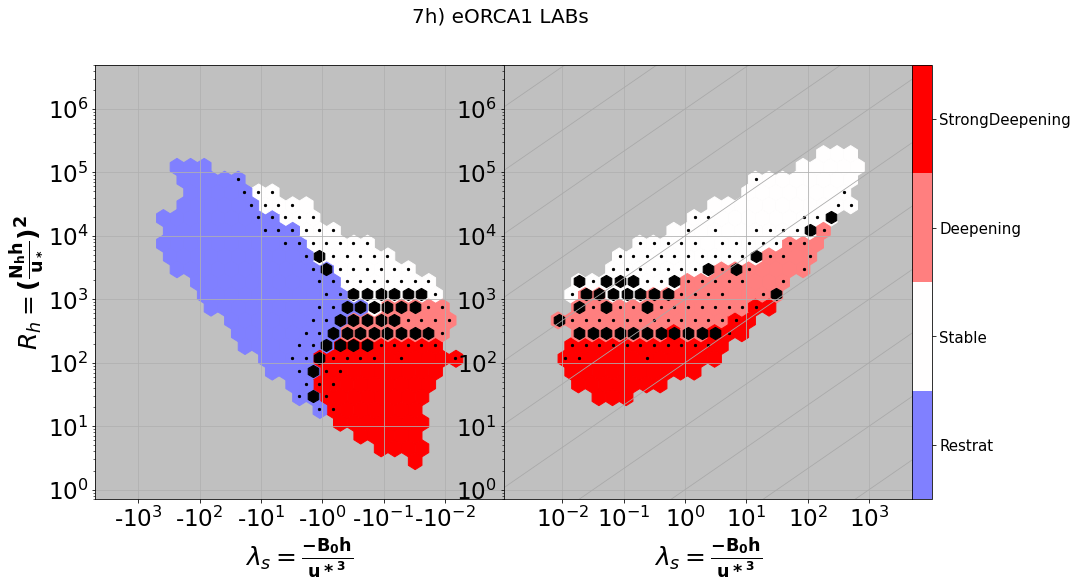

In [28]:
### 7h) eORCA1 LABs 

#### For loading eORCA1 LABs data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7h) eORCA1 LABs", fontsize = 20)


### Figure B1

NotSignif : 5.7%
Signif : 33%
HighSignif : 62%


Text(0.5, 0.98, 'B1a) 1D simulations KPP LIONb')

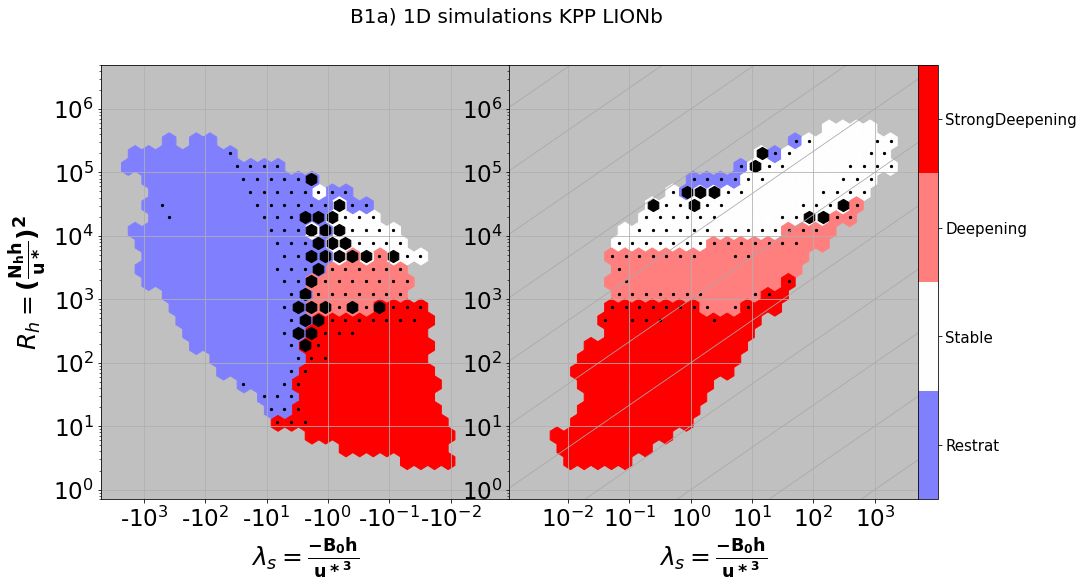

In [29]:
### B1a) 1D simulations KPP LIONb 

### For loading 1D simus LIONb data
filename = path_to_npz_archives + '1Dmodels_KPP_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"B1a) 1D simulations KPP LIONb", fontsize = 20)


NotSignif : 14%
Signif : 59%
HighSignif : 27%


Text(0.5, 0.98, 'B1b) 1D simulations KPP LABs')

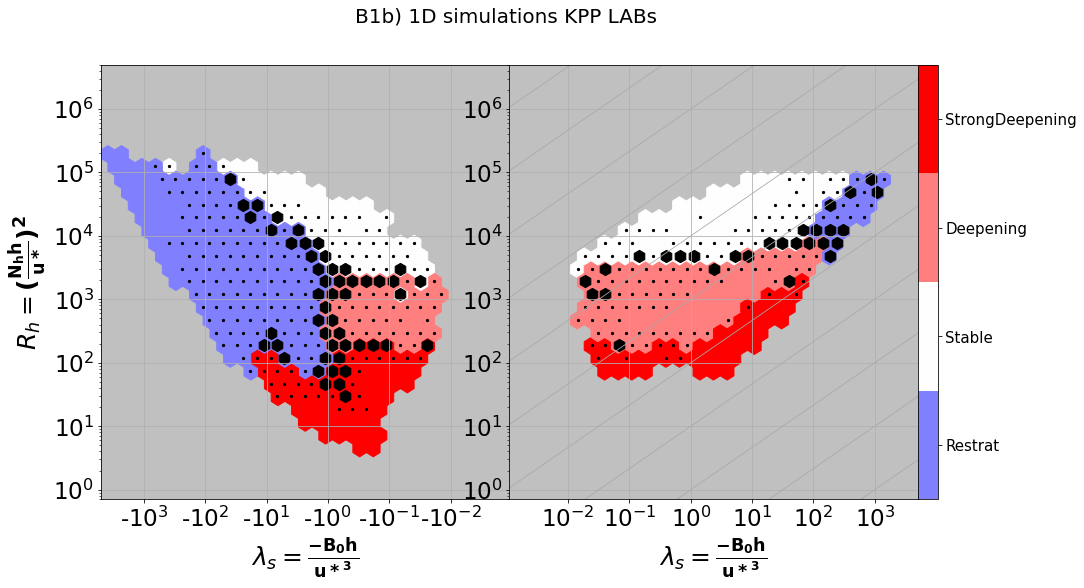

In [30]:
### B1b) 1D simulations KPP LABs 

### For loading 1D simus LABs data
filename = path_to_npz_archives + '1Dmodels_KPP_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"B1b) 1D simulations KPP LABs", fontsize = 20)


NotSignif : 9.8%
Signif : 44%
HighSignif : 46%


Text(0.5, 0.98, 'B1c) 1D simulations KPP LIONb + LABs')

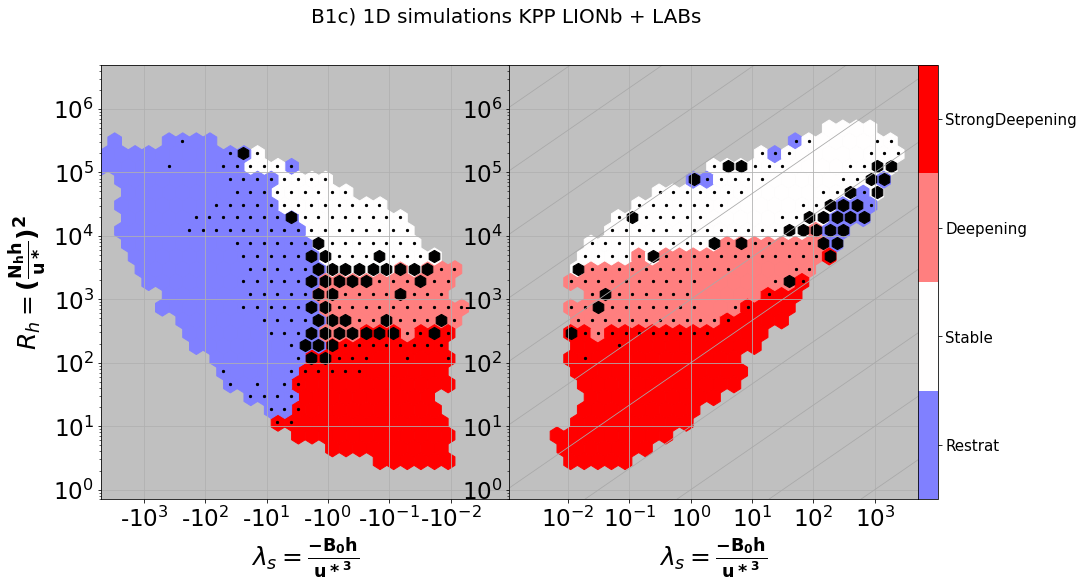

In [31]:
### B1c) 1D simulations KPP LIONb + LABs 

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + '1Dmodels_KPP_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LIONb = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LIONb  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LIONb   = data['lambdas_1Dmodels']
Rh_1Dmodels_LIONb        = data['Rh_1Dmodels']

filename = path_to_npz_archives + '1Dmodels_KPP_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LABs = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LABs  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LABs   = data['lambdas_1Dmodels']
Rh_1Dmodels_LABs        = data['Rh_1Dmodels']

dMLDdt_1Dmodels_ps      = np.concatenate((dMLDdt_1Dmodels_ps_LIONb,dMLDdt_1Dmodels_ps_LABs))
MLD_1Dmodels_b_ps       = np.concatenate((MLD_1Dmodels_b_ps_LIONb,MLD_1Dmodels_b_ps_LABs))
lambdas_1Dmodels        = np.concatenate((lambdas_1Dmodels_LIONb,lambdas_1Dmodels_LABs))
Rh_1Dmodels             = np.concatenate((Rh_1Dmodels_LIONb,Rh_1Dmodels_LABs))
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"B1c) 1D simulations KPP LIONb + LABs", fontsize = 20)


### Figure D1

NotSignif : 3.4%
Signif : 27%
HighSignif : 69%


Text(0.5, 0.98, 'D1a) 1D simulations LIONb')

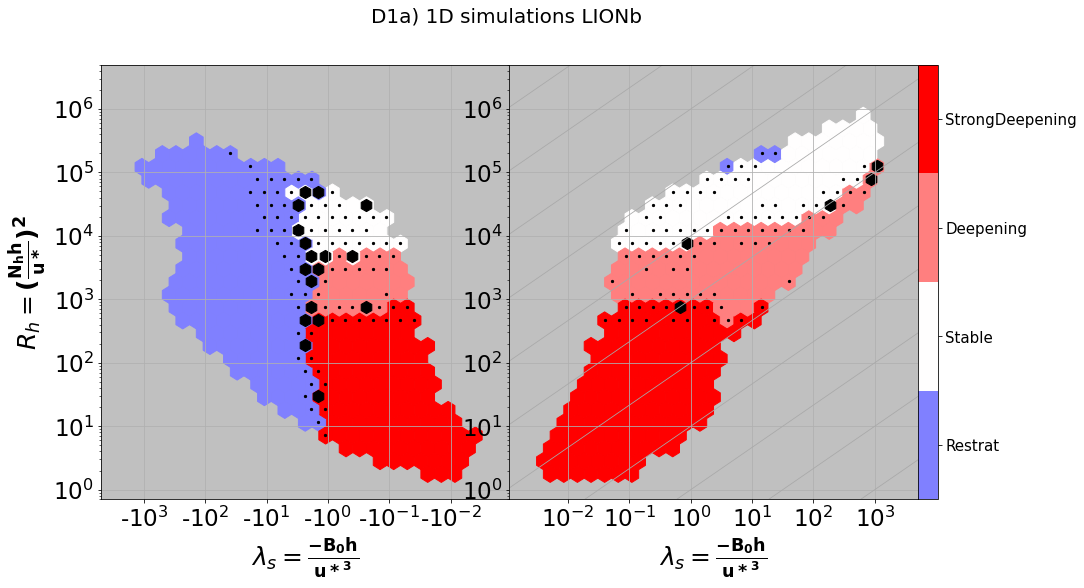

In [32]:
### D1a) 1D simulations LIONb 

### For loading 1D simus LIONb data
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1a) 1D simulations LIONb", fontsize = 20)


NotSignif : 13%
Signif : 48%
HighSignif : 39%


Text(0.5, 0.98, 'D1b) eORCA1 LIONb')

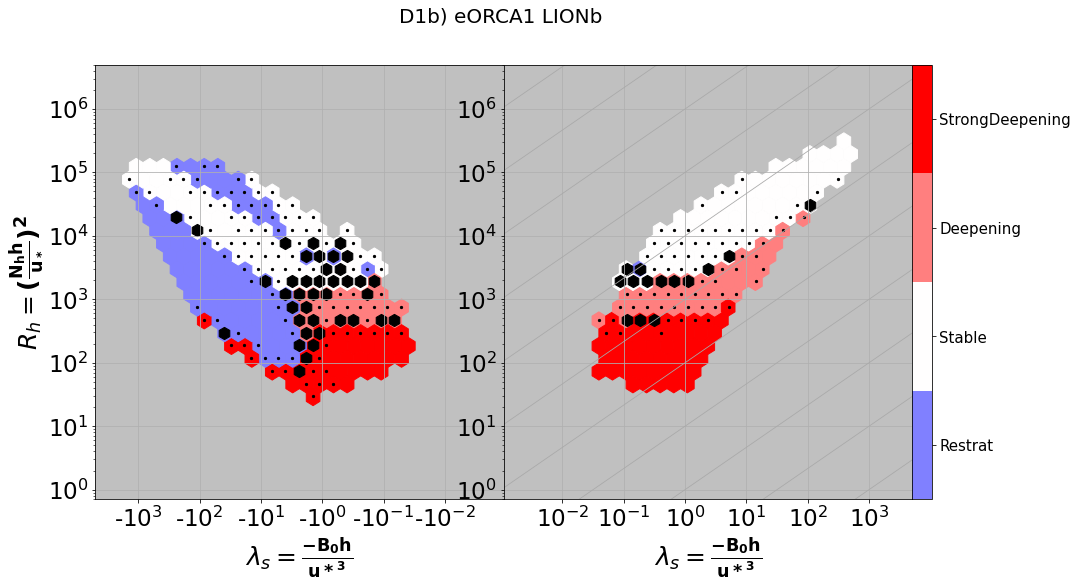

In [33]:
### D1b) eORCA1 LIONb 

#### For loading eORCA1 LIONb data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1b) eORCA1 LIONb", fontsize = 20)


NotSignif : 16%
Signif : 25%
HighSignif : 59%


Text(0.5, 0.98, 'D1c) ORCA12 LIONb')

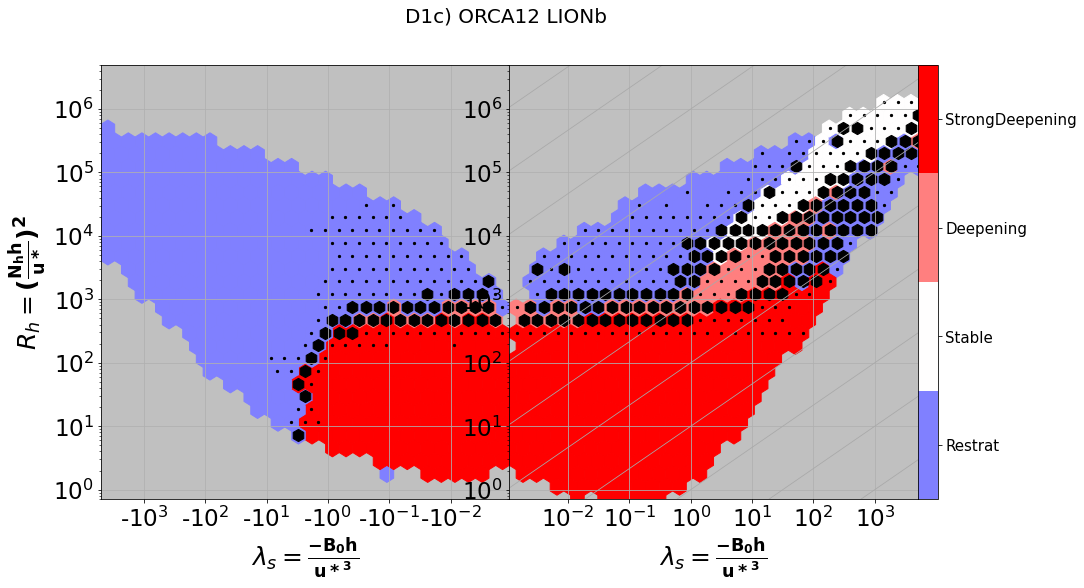

In [34]:
### D1c) eORCA12 LIONb 

### For loading eORCA12 LIONb data 
filename = path_to_npz_archives + 'ORCA12_y2006-2015_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_ORCA12_ps  = data['dMLDdt_ORCA12_ps']
MLD_ORCA12_b_ps   = data['MLD_ORCA12_b_ps']
lambdas_ORCA12    = data['lambdas_ORCA12']
Rh_ORCA12         = data['Rh_ORCA12']
dMLDdt_percent_ORCA12_ps = 100*dMLDdt_ORCA12_ps/(MLD_ORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_ORCA12
y_array = Rh_ORCA12
my_var  = dMLDdt_percent_ORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1c) ORCA12 LIONb", fontsize = 20)

NotSignif : 23%
Signif : 23%
HighSignif : 54%


Text(0.5, 0.98, 'D1d) eNATL60 LIONb')

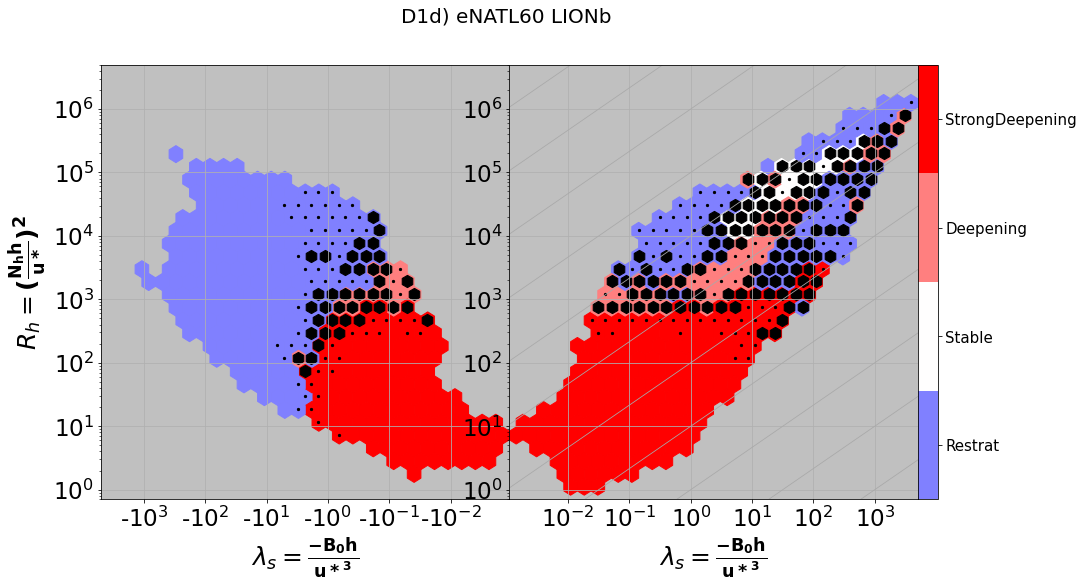

In [35]:
### D1d) eNATL60 LIONb 

### For loading eNATL60 LIONb data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1d) eNATL60 LIONb", fontsize = 20)


NotSignif : 4.9%
Signif : 42%
HighSignif : 53%


Text(0.5, 0.98, 'D1e) 1D simulations LABs')

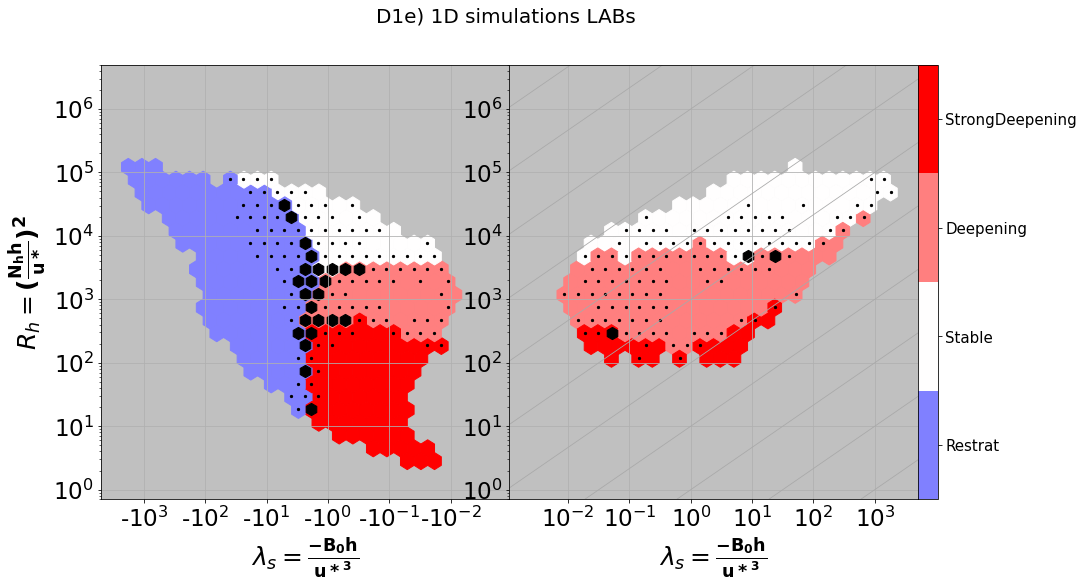

In [36]:
### D1e) 1D simulations LABs 

### For loading 1D simus LABs data
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1e) 1D simulations LABs", fontsize = 20)


NotSignif : 13%
Signif : 39%
HighSignif : 48%


Text(0.5, 0.98, 'D1f) eORCA1 LABs')

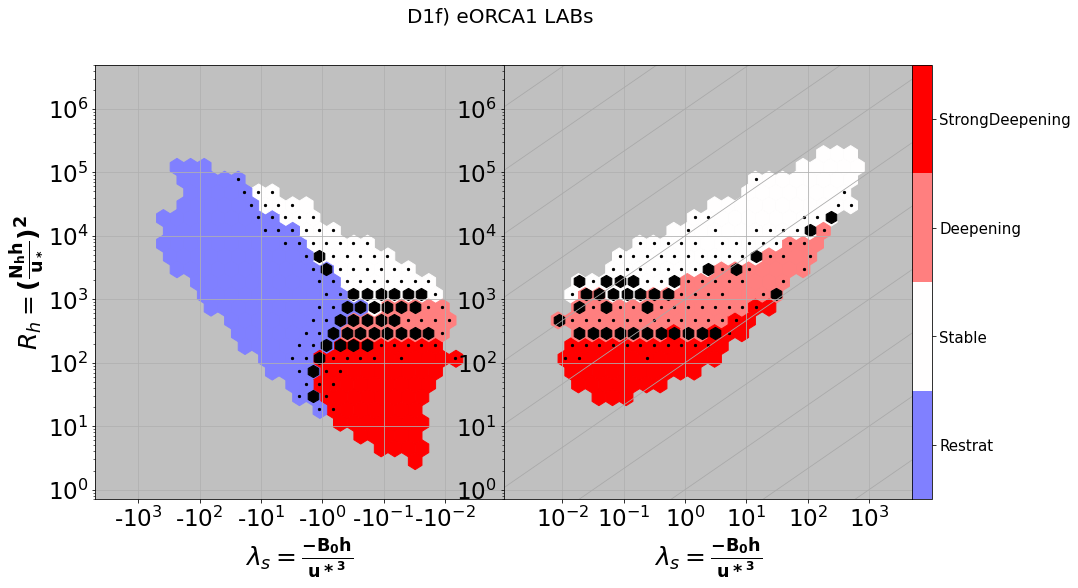

In [37]:
### D1f) eORCA1 LABs 

#### For loading eORCA1 LABs data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1f) eORCA1 LABs", fontsize = 20)


NotSignif : 33%
Signif : 20%
HighSignif : 47%


Text(0.5, 0.98, 'D1g) ORCA12 LABs')

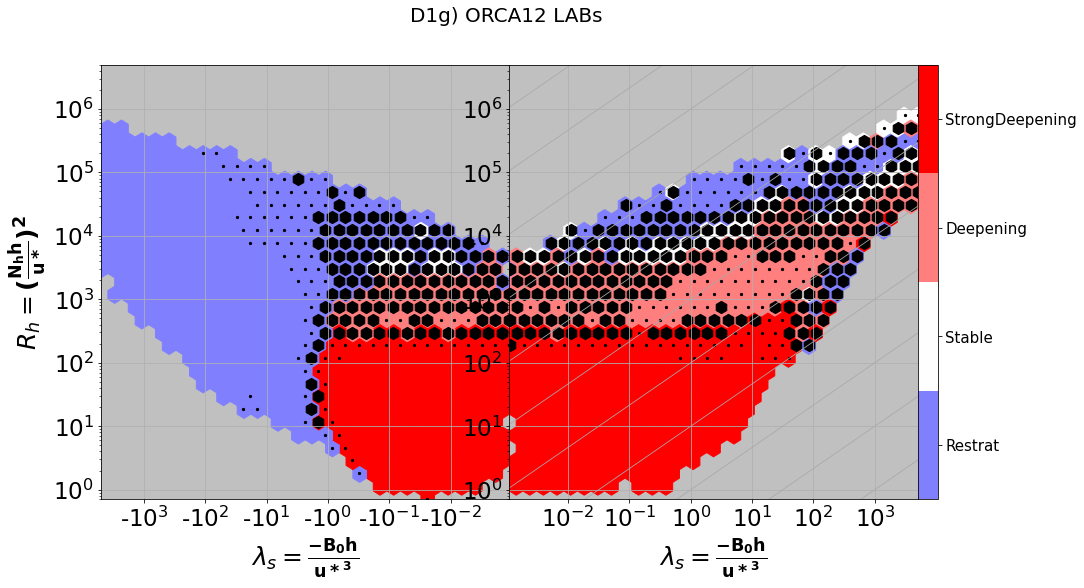

In [38]:
### D1g) eORCA12 LABs 

### For loading eORCA12 LABs data 
filename = path_to_npz_archives + 'ORCA12_y2006-2015_LABs_ps.npz'
data = np.load(filename)
dMLDdt_ORCA12_ps  = data['dMLDdt_ORCA12_ps']
MLD_ORCA12_b_ps   = data['MLD_ORCA12_b_ps']
lambdas_ORCA12    = data['lambdas_ORCA12']
Rh_ORCA12         = data['Rh_ORCA12']
dMLDdt_percent_ORCA12_ps = 100*dMLDdt_ORCA12_ps/(MLD_ORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_ORCA12
y_array = Rh_ORCA12
my_var  = dMLDdt_percent_ORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1g) ORCA12 LABs", fontsize = 20)

NotSignif : 34%
Signif : 29%
HighSignif : 37%


Text(0.5, 0.98, 'D1h) eNATL60 LABs')

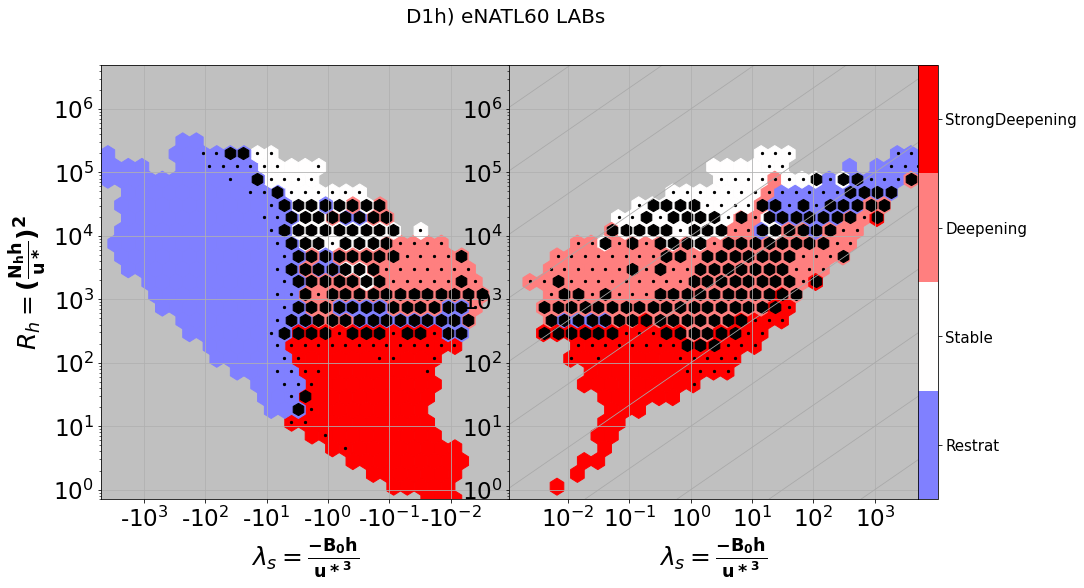

In [39]:
### D1h) eNATL60 LABs 

### For loading eNATL60 LABs data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1h) eNATL60 LABs", fontsize = 20)


NotSignif : 3.2%
Signif : 36%
HighSignif : 61%


Text(0.5, 0.98, 'D1i) 1D simulations LIONb + LABs')

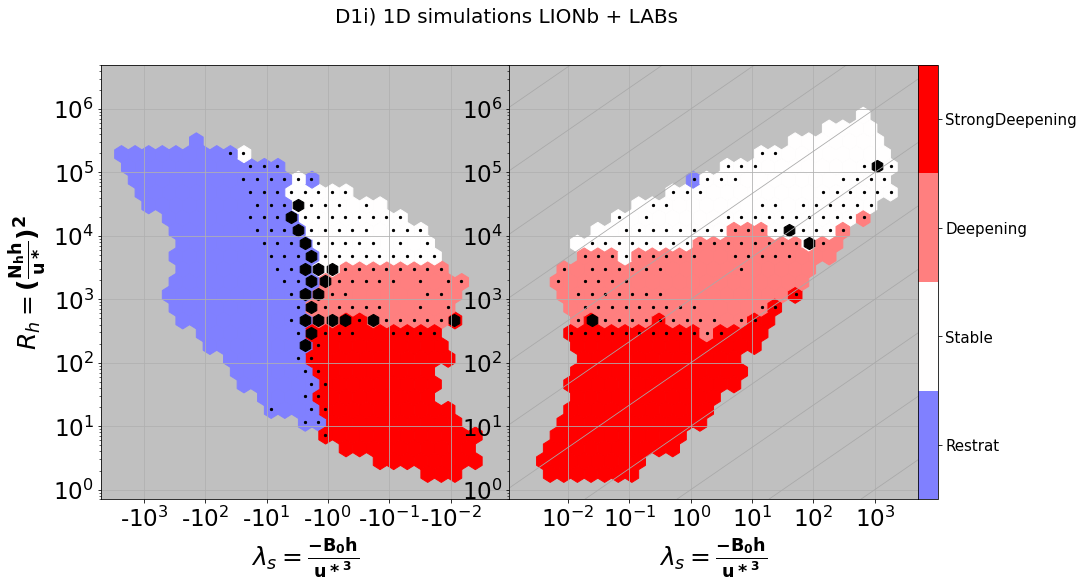

In [40]:
### D1i) 1D simulations LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LIONb = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LIONb  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LIONb   = data['lambdas_1Dmodels']
Rh_1Dmodels_LIONb        = data['Rh_1Dmodels']

filename = path_to_npz_archives + '1Dmodels_TKEevd_ntot100_nyears10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps_LABs = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps_LABs  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels_LABs   = data['lambdas_1Dmodels']
Rh_1Dmodels_LABs        = data['Rh_1Dmodels']

dMLDdt_1Dmodels_ps      = np.concatenate((dMLDdt_1Dmodels_ps_LIONb,dMLDdt_1Dmodels_ps_LABs))
MLD_1Dmodels_b_ps       = np.concatenate((MLD_1Dmodels_b_ps_LIONb,MLD_1Dmodels_b_ps_LABs))
lambdas_1Dmodels        = np.concatenate((lambdas_1Dmodels_LIONb,lambdas_1Dmodels_LABs))
Rh_1Dmodels             = np.concatenate((Rh_1Dmodels_LIONb,Rh_1Dmodels_LABs))
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1i) 1D simulations LIONb + LABs", fontsize = 20)


NotSignif : 13%
Signif : 49%
HighSignif : 38%


Text(0.5, 0.98, 'D1j) eORCA1 LIONb + LABs')

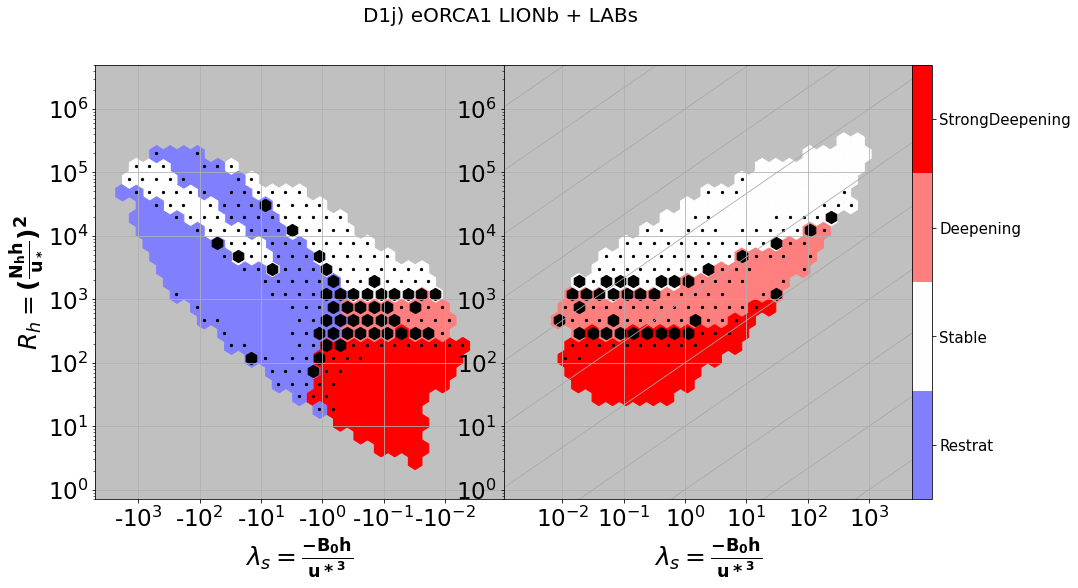

In [41]:
### D1j) eORCA1 LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps_LIONb  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps_LIONb   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1_LIONb    = data['lambdas_eORCA1']
Rh_eORCA1_LIONb         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps_LIONb = 100*dMLDdt_eORCA1_ps_LIONb/(MLD_eORCA1_b_ps_LIONb)*3600*24   # [%/day]

filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps_LABs  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps_LABs   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1_LABs    = data['lambdas_eORCA1']
Rh_eORCA1_LABs         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps_LABs = 100*dMLDdt_eORCA1_ps_LABs/(MLD_eORCA1_b_ps_LABs)*3600*24   # [%/day]

dMLDdt_eORCA1_ps      = np.concatenate((dMLDdt_eORCA1_ps_LIONb,dMLDdt_eORCA1_ps_LABs))
MLD_eORCA1_b_ps       = np.concatenate((MLD_eORCA1_b_ps_LIONb,MLD_eORCA1_b_ps_LABs))
lambdas_eORCA1        = np.concatenate((lambdas_eORCA1_LIONb,lambdas_eORCA1_LABs))
Rh_eORCA1             = np.concatenate((Rh_eORCA1_LIONb,Rh_eORCA1_LABs))
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1j) eORCA1 LIONb + LABs", fontsize = 20)


NotSignif : 29%
Signif : 21%
HighSignif : 50%


Text(0.5, 0.98, 'D1k) ORCA12 LIONb + LABs')

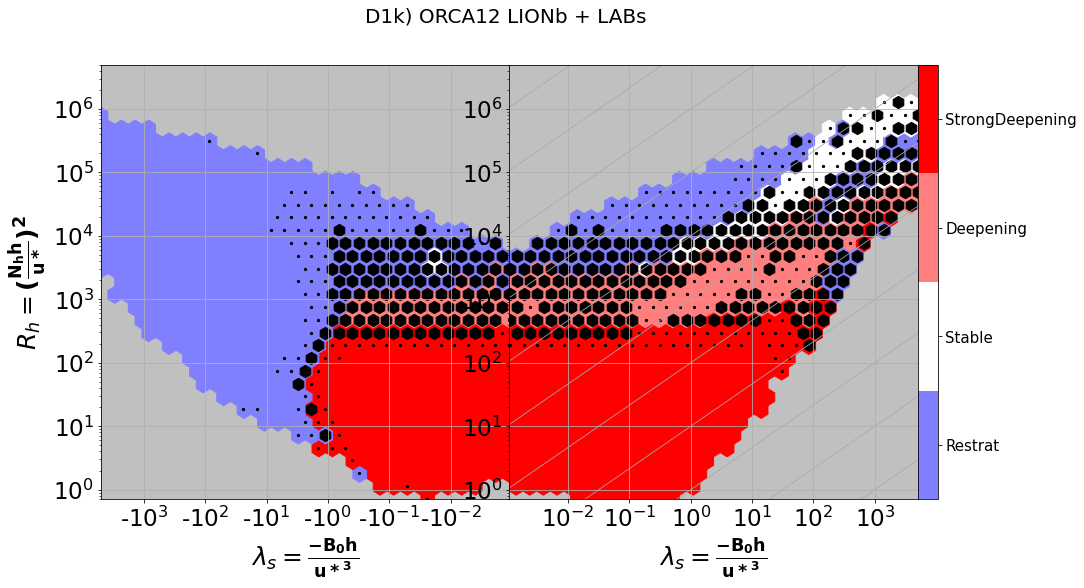

In [42]:
### D1k) ORCA12 LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + 'ORCA12_y2006-2015_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_ORCA12_ps_LIONb  = data['dMLDdt_ORCA12_ps']
MLD_ORCA12_b_ps_LIONb   = data['MLD_ORCA12_b_ps']
lambdas_ORCA12_LIONb    = data['lambdas_ORCA12']
Rh_ORCA12_LIONb         = data['Rh_ORCA12']
dMLDdt_percent_ORCA12_ps_LIONb = 100*dMLDdt_ORCA12_ps_LIONb/(MLD_ORCA12_b_ps_LIONb)*3600*24   # [%/day]

filename = path_to_npz_archives + 'ORCA12_y2006-2015_LABs_ps.npz'
data = np.load(filename)
dMLDdt_ORCA12_ps_LABs  = data['dMLDdt_ORCA12_ps']
MLD_ORCA12_b_ps_LABs   = data['MLD_ORCA12_b_ps']
lambdas_ORCA12_LABs    = data['lambdas_ORCA12']
Rh_ORCA12_LABs         = data['Rh_ORCA12']
dMLDdt_percent_ORCA12_ps_LABs = 100*dMLDdt_ORCA12_ps_LABs/(MLD_ORCA12_b_ps_LABs)*3600*24   # [%/day]

dMLDdt_ORCA12_ps      = np.concatenate((dMLDdt_ORCA12_ps_LIONb,dMLDdt_ORCA12_ps_LABs))
MLD_ORCA12_b_ps       = np.concatenate((MLD_ORCA12_b_ps_LIONb,MLD_ORCA12_b_ps_LABs))
lambdas_ORCA12        = np.concatenate((lambdas_ORCA12_LIONb,lambdas_ORCA12_LABs))
Rh_ORCA12             = np.concatenate((Rh_ORCA12_LIONb,Rh_ORCA12_LABs))
dMLDdt_percent_ORCA12_ps = 100*dMLDdt_ORCA12_ps/(MLD_ORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_ORCA12
y_array = Rh_ORCA12
my_var  = dMLDdt_percent_ORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1k) ORCA12 LIONb + LABs", fontsize = 20)


NotSignif : 32%
Signif : 22%
HighSignif : 46%


Text(0.5, 0.98, 'eNATL60 LIONb + LABs')

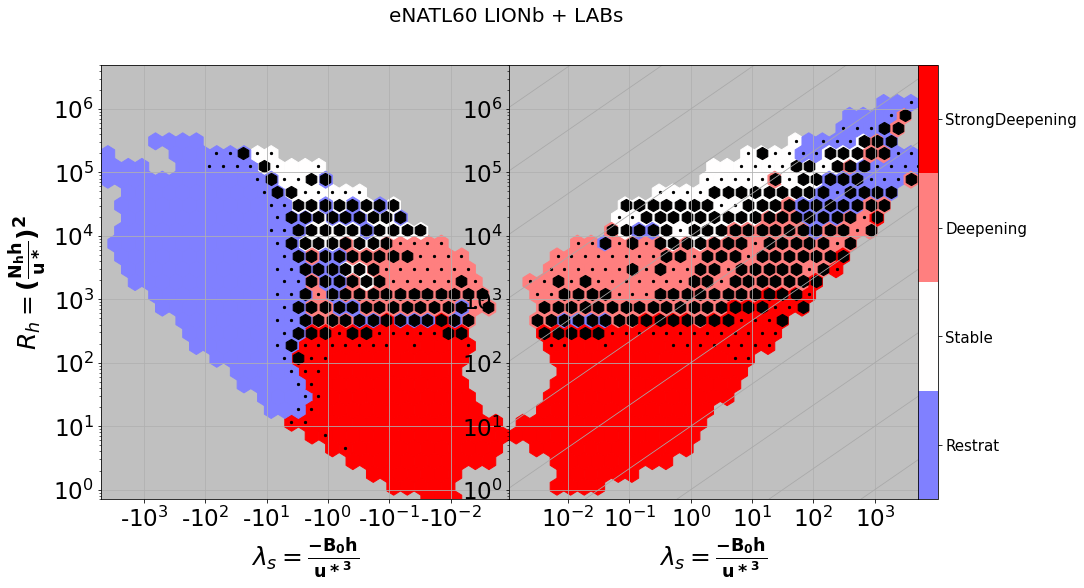

In [43]:
### D1l) eNATL60 LIONb + LABs

### Loading LIONb and LABs and gather them as a single dataset 
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps_LIONb  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps_LIONb   = data['MLD_eNATL60_b_ps']
lambdas_eNATL60_LIONb    = data['lambdas_eNATL60']
Rh_eNATL60_LIONb         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps_LIONb = 100*dMLDdt_eNATL60_ps_LIONb/(MLD_eNATL60_b_ps_LIONb)*3600*24   # [%/day]

filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps_LABs  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps_LABs   = data['MLD_eNATL60_b_ps']
lambdas_eNATL60_LABs    = data['lambdas_eNATL60']
Rh_eNATL60_LABs         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps_LABs = 100*dMLDdt_eNATL60_ps_LABs/(MLD_eNATL60_b_ps_LABs)*3600*24   # [%/day]

dMLDdt_eNATL60_ps      = np.concatenate((dMLDdt_eNATL60_ps_LIONb,dMLDdt_eNATL60_ps_LABs))
MLD_eNATL60_b_ps       = np.concatenate((MLD_eNATL60_b_ps_LIONb,MLD_eNATL60_b_ps_LABs))
lambdas_eNATL60        = np.concatenate((lambdas_eNATL60_LIONb,lambdas_eNATL60_LABs))
Rh_eNATL60             = np.concatenate((Rh_eNATL60_LIONb,Rh_eNATL60_LABs))
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = class_MLdynamics  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"eNATL60 LIONb + LABs", fontsize = 20)